# Predicting of footbal results

## Imports

In [1]:
# coding: utf-8
import numpy as np
import pandas as pd

# pandas settings
pd.set_option('display.max_rows', 45000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.max_colwidth', 5000)

# for graphics
import seaborn as sns
import matplotlib.pyplot as plt

# for own libs
import sys
sys.path.append('//')

# lib for working with SQL
import data_load as dl
# usefull functions
import predict_fucntions as pf

# date manipiulations
import datetime
from datetime import timedelta
from datetime import datetime

# ml models
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# default graph size
from pylab import rcParams
rcParams['figure.figsize'] = 18, 12

## Parameters

In [2]:
# switch on/off hyperparamaters search 
# (running 30 or 2 minutes)
is_hyper_search = 0

# list for future model comparison
predict_parameters = []

# tranin test dates for split    
train_border1 = datetime.strptime("1994-06-01", "%Y-%m-%d")
train_border2 = datetime.strptime("2022-10-01", "%Y-%m-%d")

test_border1 = train_border2
test_border2 = datetime.strptime("2022-11-01", "%Y-%m-%d")

# dividing by high and low leagues
second_leagues_lst = [
    141, # Spain Segunda
    40, # England championship
    136, # Italy Serie B
    79, # Germany Bundes 2
    62, # Frace Liga 2
]

## Data load

In [3]:
# math results
# main dataset
matches_results = dl.get_data("""

select *
from sport.footbalapi_match_results mr
where status='FT'  and league_id not in (
                                            1, 4, 5, 9 -- national teams
                                            --, 2, 3, 848 -- eurocups
                                        )

""")
matches_results = matches_results.rename(columns={'venue': 'stadium'})

In [4]:
# match stat: ball posesion, shots etc
match_stat = dl.get_data("""

select *
from sport.footbalapi_match_stat

""")

In [5]:
# match stat by players
indiv_mark = dl.get_data("""
select match_id, team_id, avg(mark) as avg_mark
from 
(
    select 
            case 
                when mark='–' then 0
                else mark::float
            end as mark
            , team_id
            , match_id
    from sport.footbalapi_pers_stat
) t1
group by match_id, team_id
--order by 1

""")

In [6]:
bet_df = pd.read_csv('bets2022.csv')
bet_df = bet_df[[
    'Date',
    'TeamName', 'AwayTeam',
    'FTHG', 'FTAG',
    'WHH', 'WHD', 'WHA'
]]
bet_df.columns = [
    'date',
    'home', 'away',
    'home_score', 'away_score',
    'cf1', 'cfdr', 'cf2'
]

In [7]:
bet_df.sample(3)

,date,home,away,home_score,away_score,cf1,cfdr,cf2
951,2022-09-03,Solihull,Altrincham,5,1,1.52,3.8,5.50
3258,2022-09-10,Giannina,Levadeiakos,2,1,2.05,3.0,3.60
1009,2022-10-04,Halifax,York,1,0,2.50,3.1,2.62


## What's about dataset?

In [8]:
len(matches_results)

43393

In [9]:
matches_results['date'] = matches_results['date'].astype('datetime64[ns]').dt.date
bet_df['date'] = bet_df['date'].astype('datetime64[ns]').dt.date
matches_results = matches_results.merge(
    bet_df, 'left', on=['date', 'home'], indicator=True, suffixes=('', '_from_bets')
)

In [10]:
matches_results.sample(3)

,match_id,home,away,home_score,away_score,date,home_id,away_id,coutry,league_name,league_id,season,round,stadium,status,source,insert_time,away_from_bets,home_score_from_bets,away_score_from_bets,cf1,cfdr,cf2,_merge
1740,27271,Real Betis,Real Sociedad,1,0,2018-12-02,543,548,Spain,La Liga,140,2018,14,Benito Villamarín,FT,football.api-sports.io,2022-09-14 05:14:42.434971,NaN,NaN,NaN,NaN,NaN,NaN,left_only
17540,8666,Lazio,Inter,2,3,2018-05-20,487,505,Italy,Serie A,135,2017,38,Stadio Olimpico,FT,football.api-sports.io,2022-09-27 07:12:21.758341,NaN,NaN,NaN,NaN,NaN,NaN,left_only
24180,11386,Eintracht Braunschweig,Holstein Kiel,0,0,2017-12-08,744,191,Germany,2. Bundesliga,79,2017,17,Eintracht-Stadion,FT,football.api-sports.io,2022-09-27 07:12:35.894255,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [11]:
matches_results['league_name'].value_counts()

Championship                     5813
Serie A                          3950
Premier League                   3946
Ligue 2                          3858
La Liga                          3852
Ligue 1                          3852
UEFA Europa League               3480
2. Bundesliga                    3215
Bundesliga                       3203
Segunda División                 3014
UEFA Champions League            2248
Serie B                          2218
UEFA Europa Conference League     744
Name: league_name, dtype: int64

In [12]:
matches_results['season'].value_counts()

2021    4709
2017    4691
2016    4667
2018    4595
2020    4438
2019    4040
2014    3753
2015    3748
2013    3279
2012    3273
2022    2200
Name: season, dtype: int64

In [13]:
matches_results[['home_score', 'away_score']].describe()

,home_score,away_score
count,43393.000000,43393.000000
mean,1.482497,1.153227
std,1.272049,1.128316
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,10.000000,9.000000


In [14]:
matches_results.groupby(['home_score', 'away_score']).agg(
                {
                    'match_id': lambda x: x.nunique(),
                }).reset_index().sort_values(by='match_id', ascending=False)[0:10]

,home_score,away_score,match_id
11,1,1,5375
10,1,0,4473
19,2,1,3773
0,0,0,3478
1,0,1,3375
18,2,0,3328
12,1,2,2860
20,2,2,2162
2,0,2,2038
27,3,0,1879


In [15]:
matches_results.groupby(['league_name']).agg(
                {
                    'match_id': lambda x: x.nunique(),
                    'home_score': np.mean,
                    'away_score': np.mean,
                }).reset_index().sort_values(by='home_score', ascending=False)[0:10]

,league_name,match_id,home_score,away_score
1,Bundesliga,3203,1.668748,1.325944
10,UEFA Champions League,2248,1.609875,1.213078
11,UEFA Europa Conference League,744,1.577957,1.102151
12,UEFA Europa League,3480,1.548563,1.137931
8,Serie A,3950,1.534430,1.248608
3,La Liga,3852,1.532710,1.139668
6,Premier League,3946,1.525849,1.215661
0,2. Bundesliga,3215,1.501711,1.229860
4,Ligue 1,3852,1.475857,1.139148
2,Championship,5813,1.420609,1.137623


## First step of data prepairing

In [16]:
# main format
matches_results = pf.formatting(matches_results, gh='home_score', ga='away_score')
# df for work - one macth = 2 rows for every team
team_based_df = pf.team_table(matches_results)
# additional fields
team_based_df = team_based_df.merge(
                                    matches_results[[
                                        'match_id',
                                        'coutry', 'league_name', 'league_id', 
                                        'season', 'round', 'stadium',
                                        'cf1', 'cfdr', 'cf2',
                                                    ]], 
                                    'left',
                                    on=['match_id'],
                                   )
    
# dividing by high and low leagues
team_based_df['is_high_league'] = np.where(
                                team_based_df['league_id'].isin(second_leagues_lst), 0, 1
                                       )

In [17]:
team_based_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league
18367,18914,197017,2015-02-22,AS Roma,Verona,Away,Draw,1,1,497,504,107,18360,1,0.5,1,0,0,0,58,27,22,189,114,Italy,Serie A,135,2014,24,Stadio Marc'Antonio Bentegodi (Verona),NaN,NaN,NaN,1
39518,13138,12368,2017-09-23,Sunderland,Cardiff,Home,Lose,1,2,746,43,199,39548,0,0.0,0,1,0,0,42,58,99,198,312,England,Championship,40,2017,9,Stadium of Light,NaN,NaN,NaN,0
33196,5241,21067,2017-01-08,Oviedo,Sevilla Atletico,Away,Lose,3,5,718,730,20,33196,0,0.0,0,1,0,0,7,5,8,22,25,Spain,Segunda División,141,2016,20,Ciudad Deportiva Jose Ramon Cisneros Palacios,NaN,NaN,NaN,0


In [18]:
team_based_df['team'].nunique()

779

In [19]:
team_based_df[['game_number']].describe()

,game_number
count,86786.000000
mean,160.642258
std,123.926755
min,1.000000
25%,50.000000
50%,137.000000
75%,254.000000
max,504.000000


In [20]:
team_based_df[['date']].describe(datetime_is_numeric=True)

,date
count,86786
mean,2018-01-11 14:07:02.943792896
min,2012-07-03 00:00:00
25%,2015-08-25 00:00:00
50%,2018-02-03 00:00:00
75%,2020-10-03 00:00:00
max,2022-12-08 00:00:00


In [21]:
rrqq = pd.DataFrame(team_based_df[team_based_df['venue']=='Home']['result'].value_counts())
rrqq['share'] = rrqq['result']/np.sum(rrqq['result'])

In [22]:
rrqq

,result,share
Win,19184,0.442099
Lose,12731,0.293388
Draw,11478,0.264513


## Train test split

In [23]:
team_based_df['y'] = team_based_df['result']
train_df, test_df = pf.df_date_split(
                                                        team_based_df, 
                                                        train_border1, 
                                                        train_border2, 
                                                        test_border1, 
                                                        test_border2,
                                                                    )
work_df = test_df.copy()
work_df = work_df.merge(
    team_based_df[['id', 'date', 'cf1', 'cfdr', 'cf2',]],
    'left',
    on='id'
)
work_df['date'] = work_df['date'].astype('datetime64[ns]').dt.date

train, len: 84816
test, len: 1264


In [24]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y
85756,85758,Cittadella,Palermo,Away,510,522,Draw
85961,86009,Leganes,Racing Santander,Home,537,4665,Draw
85251,85265,Lens,Lille,Away,116,79,Lose


In [25]:
work_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,date,cf1,cfdr,cf2
760,85572,Liverpool,Manchester City,Home,40,50,Win,2022-10-16,3.7,3.9,1.88
570,85374,Qarabag,Olympiakos Piraeus,Home,556,553,Draw,2022-10-13,NaN,NaN,NaN
428,85243,Verona,Salernitana,Away,504,514,Lose,2022-10-09,2.4,3.5,2.80


In [26]:
work_df[
    (work_df['team']=='Everton') &
    (work_df['opponent']=='Manchester United')
]

,id,team,opponent,venue,team_id,opponent_team_id,y,date,cf1,cfdr,cf2
448,85240,Everton,Manchester United,Home,45,33,Lose,2022-10-09,3.5,3.5,2.05


## Model way

In [27]:
# formatting: формат и типы данных, проверка на null 
# enriched: обогащение полями, id команд, номер игры в жизни, навесить рейтинги, историю личных встреч и т.п.
# preprocessing: выбор фичей, нормализация, ohe
# predicting: обучние модели
# watching: оценка результата

## Model #0: Her Higness Random

In [28]:
# result of game is always random

In [29]:
# formatting: No  need
# enriched: No need
# preprocessing: No need

In [30]:
# predicting:
y_random_predict = test_df[['team', 'opponent']].apply(
                    lambda x: pf.random_predict(x[0], x[1], seed=42), axis=1)
work_df['random_predict'] = y_random_predict.values

In [31]:
work_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,date,cf1,cfdr,cf2,random_predict
1209,86024,FC Cartagena,Granada CF,Home,5262,715,Draw,2022-10-30,2.5,3.2,2.8,Draw
1141,85956,Spal,Sudtirol,Home,493,1578,Draw,2022-10-29,2.2,3.0,3.6,Draw
422,85252,FC Heidenheim,Hannover 96,Home,180,166,Win,2022-10-09,NaN,NaN,NaN,Draw


,size,accuracy,f1,roi,segment,model
0,1264,0.254747,0.135351,-0.428706,1,random


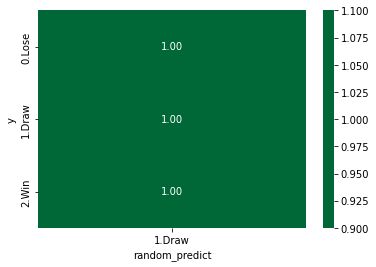

In [32]:
# watching:
# the model result
pf.model_results(work_df, 'random', 'random_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

'rating_difference'


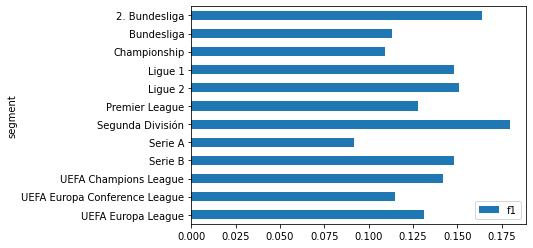

In [33]:
# different tests
work_df = work_df.merge(team_based_df, 'left', on='id', suffixes=('', '_enreached'))
hl, leagues, venue, fi, comparison_df = pf.watching(work_df, 'random_predict', '', [], predict_parameters)

In [34]:
hl

,size,accuracy,f1,roi,segment
0,694,0.230548,0.124902,-0.469615,1
1,570,0.284211,0.147541,-0.378056,0


In [35]:
venue

,size,accuracy,f1,roi,segment
0,632,0.254747,0.135351,-0.428706,Home
1,632,0.254747,0.135351,-0.428706,Away


## Model #1: simple predict

In [36]:
# home team always win

In [37]:
# formatting: No  need
# enriched: No need
# preprocessing: No need

In [38]:
# predicting:
y_simple_predict = test_df[['team', 'opponent']].apply(
                    lambda x: pf.simple_predict(x[0], x[1]), axis=1)
work_df['simple_predict'] = y_simple_predict.values

In [39]:
work_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,date,cf1,cfdr,cf2,random_predict,revenue,global_segment,index,match_id,date_enreached,team_enreached,opponent_enreached,venue_enreached,result,team_score,opponent_score,team_id_enreached,opponent_team_id_enreached,game_number,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1_enreached,cfdr_enreached,cf2_enreached,is_high_league,y_enreached,simple_predict
970,85753,FC Schalke 04,Hertha Berlin,Away,174,159,Lose,2022-10-23,1.75,3.7,4.5,Draw,0.0,1,42903,871262,2022-10-23,FC Schalke 04,Hertha Berlin,Away,Lose,1,2,174,159,404,0,0.0,0,1,0,0,156,101,147,572,604,Germany,Bundesliga,78,2022,11,Olympiastadion Berlin,1.75,3.7,4.5,1,Lose,Win
748,85563,Rennes,Lyon,Home,94,80,Win,2022-10-16,2.25,3.5,3.0,Draw,0.0,1,43200,871577,2022-10-16,Rennes,Lyon,Home,Win,3,2,94,80,417,3,1.0,0,0,1,0,164,111,142,569,503,France,Ligue 1,61,2022,11,Roazhon Park,2.25,3.5,3.0,1,Win,Win
194,84997,Liverpool,Rangers,Home,40,257,Win,2022-10-04,NaN,NaN,NaN,Draw,0.0,1,41566,946883,2022-10-04,Liverpool,Rangers,Home,Win,2,0,40,257,470,3,1.0,0,0,1,1,278,110,82,962,490,World,UEFA Champions League,2,2022,3,Anfield,NaN,NaN,NaN,1,Win,Win


,size,accuracy,f1,roi,segment,model
0,1264,0.372627,0.18098,-0.316536,1,simple_predict


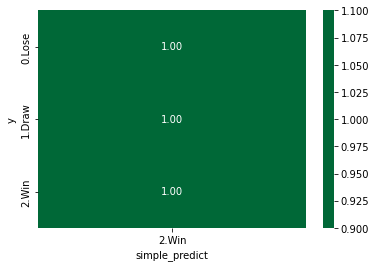

In [40]:
# watching:
# the model result
pf.model_results(work_df, 'simple_predict', 'simple_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

'rating_difference'


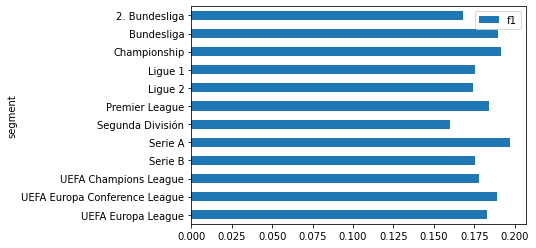

In [41]:
hl, leagues, venue, fi, comparison_df = pf.watching(work_df, 'simple_predict', '', [], predict_parameters)

In [42]:
hl

,size,accuracy,f1,roi,segment
0,694,0.384726,0.185224,-0.314041,1
1,570,0.357895,0.175711,-0.319376,0


In [43]:
venue

,size,accuracy,f1,roi,segment
0,632,0.447785,0.206193,-0.256805,Home
1,632,0.297468,0.152846,-0.372779,Away


In [44]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict


## Model #2: Direct ELO

https://en.wikipedia.org/wiki/Elo_rating_system

In [45]:
# enriched: get ratings

In [46]:
# counting elo rating
team_based_df, dct = pf.count_elo_rating_df(team_based_df)

In [47]:
start_ratings = pd.read_csv('start_ratings.csv')

In [48]:
start_ratings[0:3]

,team,id,start_rating
0,Barcelona,529,2638.0
1,Atletico Madrid,530,2638.0
2,Athletic Club,531,2638.0


In [49]:
team_based_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability
79082,20014,747252,2022-02-12,Perugia,Frosinone,Home,Win,3,0,524,512,145,79097,3,1.0,0,0,1,1,53,51,41,196,171,Italy,Serie B,136,2021,22,Stadio Renato Curi,NaN,NaN,NaN,0,Win,2509.63,2505.77,3.86,0.51
31526,24528,17213,2016-11-05,FC Kaiserslautern,Union Berlin,Home,Win,1,0,745,182,148,31538,3,1.0,0,0,1,1,60,48,40,213,162,Germany,2. Bundesliga,79,2016,12,Fritz-Walter-Stadion,NaN,NaN,NaN,0,Win,2525.38,2543.95,-18.57,0.47
5448,28720,186994,2013-04-07,Lorient,Lille,Away,Lose,0,5,97,79,31,5438,0,0.0,0,1,0,0,11,11,9,48,50,France,Ligue 1,61,2012,31,Grand Stade Lille Métropole (Villeneuve d'Ascq),NaN,NaN,NaN,1,Lose,2454.57,2634.81,-180.24,0.26


In [50]:
# fresh ratings
current_game_num = team_based_df.groupby('team')[['game_number']].max().reset_index()

with_now_df = team_based_df.merge(current_game_num, 'left', on='team', suffixes=('', '_fresh'))
now_df = with_now_df[with_now_df['game_number'] == with_now_df['game_number_fresh']]

In [51]:
now_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,game_number_fresh
64446,34026,606553,2020-09-17,Kaisar,Apoel Nicosia,Home,Lose,1,4,4562,2247,1,64463,0,0.0,0,1,0,0,0,0,1,1,4,World,UEFA Europa League,3,2020,2nd Qualifying Round,Gany Muratbayev Stadium,NaN,NaN,NaN,1,Lose,2361.38,2461.10,-99.72,0.36,1
12713,15461,446539,2014-05-03,Yeovil Town,Middlesbrough,Home,Lose,1,4,1377,70,46,12772,0,0.0,0,1,0,0,8,13,25,44,75,England,Championship,40,2013,46,Huish Park Stadium,NaN,NaN,NaN,0,Lose,2410.78,2515.83,-105.05,0.35,46
64477,34039,606569,2020-09-17,Dinamo Moscow,Lokomotivi Tbilisi,Away,Lose,1,2,1088,3500,15,64512,0,0.0,0,1,0,0,9,4,2,21,14,World,UEFA Europa League,3,2020,2nd Qualifying Round,Mikheil Meskhi Stadium,NaN,NaN,NaN,1,Lose,2579.95,2356.10,223.85,0.78,15


In [52]:
now_df[['rating']].describe()

,rating
count,779.000000
mean,2431.533248
std,135.538762
min,2099.480000
25%,2326.765000
50%,2434.150000
75%,2510.435000
max,2920.790000


In [53]:
now_df.groupby(['season']).agg(
                {
                    'team_id': lambda x: x.nunique(),
                    'rating': lambda x: np.round(np.mean(x),0),
                })

,team_id,rating
season,,
2012,4,2467.0
2013,7,2394.0
2014,47,2387.0
2015,25,2388.0
2016,25,2404.0
2017,39,2412.0
2018,49,2379.0
2019,39,2390.0
2020,57,2401.0


In [54]:
now_df.groupby(['league_name']).agg(
                {
                    'team_id': lambda x: x.nunique(),
                    'rating': lambda x: np.round(np.mean(x),0),
                }).sort_values(by='rating', ascending=False)

,team_id,rating
league_name,,
Premier League,20,2682.0
Bundesliga,18,2649.0
Ligue 1,21,2632.0
Serie A,22,2616.0
La Liga,13,2560.0
UEFA Champions League,26,2557.0
2. Bundesliga,29,2452.0
Serie B,39,2429.0
Championship,36,2427.0


In [55]:
best_teams = now_df.groupby(['team']).agg(
                {
                    'rating': lambda x: np.round(np.mean(x),0),
                    'game_number': np.mean,
                }).sort_values(by='rating', ascending=False)[0:10]
best_teams

,rating,game_number
team,,
Manchester City,2921.0,497.0
Bayern Munich,2902.0,469.0
Liverpool,2896.0,480.0
Paris Saint Germain,2887.0,484.0
Real Madrid,2872.0,504.0
AC Milan,2848.0,457.0
Napoli,2828.0,485.0
Inter,2820.0,455.0
Arsenal,2819.0,494.0


<AxesSubplot: title={'center': 'Rating dynamics'}, xlabel='game_number'>

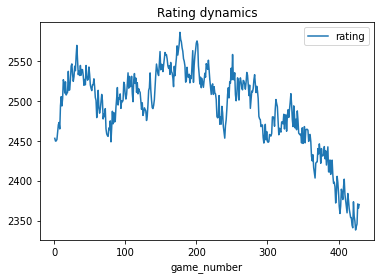

In [56]:
current_teams = ['Malaga']
team_based_df[team_based_df['team'].isin(current_teams)][[
    'team', 'game_number', 'date', 'rating', 'league_id'
 ]].set_index('game_number')[['rating']].plot(title='Rating dynamics')

<AxesSubplot: title={'center': 'AC Milan'}, xlabel='game_number'>

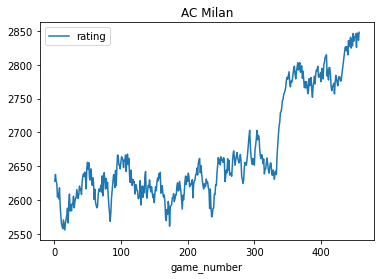

In [57]:
current_team = 'AC Milan'
team_based_df[team_based_df['team'] == current_team][[
    'team', 'game_number', 'date', 'rating', 'league_id'
 ]].set_index('game_number')[['rating']].plot(title=current_team)

<AxesSubplot: xlabel='game_number', ylabel='rating'>

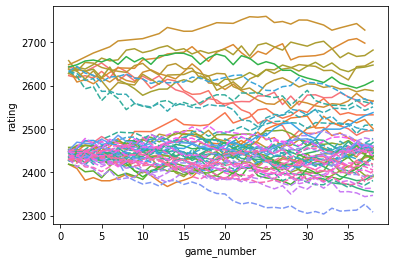

In [58]:
sns.lineplot(
    data=team_based_df[
        (team_based_df['game_number'] <= 38) &
        (team_based_df['coutry'] == 'Spain') &
        (team_based_df['rating'] > 2300)
                        ], 
    x='game_number', 
    y='rating', 
    hue='team',
    legend=False,
    style='league_name',
            )

<AxesSubplot: xlabel='game_number', ylabel='rating'>

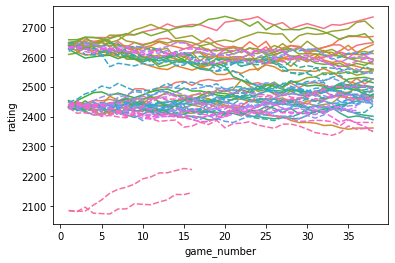

In [59]:
sns.lineplot(
    data=team_based_df[
        (team_based_df['game_number'] <= 38) &
        (team_based_df['coutry'] == 'Italy')
                        ], 
    x='game_number', 
    y='rating', 
    hue='team',
    legend=False,
    style='league_name',
            )

<AxesSubplot: xlabel='game_number', ylabel='rating'>

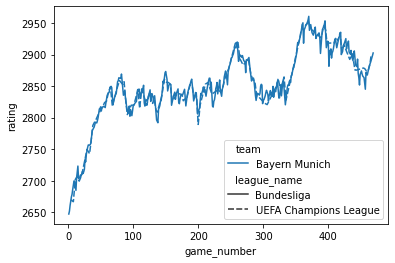

In [60]:
sns.lineplot(
    data=team_based_df[
        (team_based_df['team'].isin(best_teams.index[1:2])) 
                        ], 
    x='game_number', 
    y='rating', 
    hue='team',
    legend=True,
    style='league_name',
            )

In [61]:
team_based_df[
        (team_based_df['team'].isin(best_teams.index[1:2])) 
                        ].groupby('league_name')[['rating']].mean()

,rating
league_name,
Bundesliga,2850.632732
UEFA Champions League,2851.846842


In [62]:
team_based_df[
        (team_based_df['team'].isin(best_teams.index[4:5])) 
                        ].groupby('league_name')[['rating']].mean()

,rating
league_name,
La Liga,2802.640234
UEFA Champions League,2809.652773


<AxesSubplot: xlabel='game_number', ylabel='rating'>

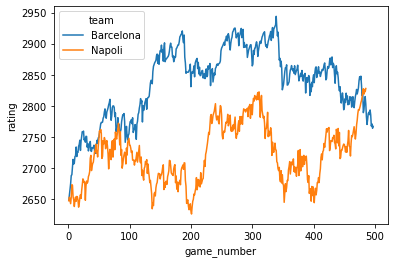

In [63]:
sns.lineplot(
    data=team_based_df[
        (team_based_df['team'].isin(['Napoli', 'Barcelona'])) 
                        ], 
    x='game_number', 
    y='rating', 
    hue='team',
    legend=True,
#     style='league_name',
            )

In [64]:
# enriched:
# counting elo rating
train_df, current_rating_dict = pf.count_elo_rating_df(train_df)

In [65]:
# preprocessing:
test_df['rating'] = test_df['team'].map(current_rating_dict) 
test_df['opponent_rating'] = test_df['opponent'].map(current_rating_dict) 
test_df['rating_difference'] = test_df['rating'] - test_df['opponent_rating']

test_df['elo_propability']=test_df[['rating', 'opponent_rating']].apply(
                lambda x: np.round(
                       pf.elo_prob(
                                x[0], 
                                x[1] 
                                ),2), axis=1)

In [66]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability
85516,85436,Cardiff,Coventry,Home,43,1346,Lose,2385.65,2402.91,-17.26,0.48
85510,85474,Blackburn,Middlesbrough,Away,67,70,Win,2466.98,2463.93,3.05,0.50
85492,85469,Niort,Grenoble,Home,113,101,Lose,2362.15,2411.79,-49.64,0.43


In [67]:
# predicting:
y_diret_elo = test_df['elo_propability'].apply(
                lambda x: pf.elo_prob_predict(x, 0.15))

work_df['direct_elo_predict'] = y_diret_elo.values

,size,accuracy,f1,roi,segment,model
0,1264,0.422468,0.413507,0.145019,1,direct_elo


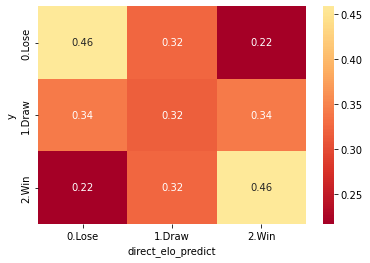

In [68]:
# watching:
pf.model_results(work_df, 'direct_elo', 'direct_elo_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

'rating_difference'


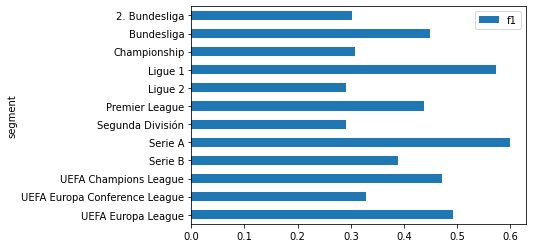

In [69]:
hl, leagues, venue, fi, comparison_df = pf.watching(work_df, 'direct_elo_predict', '', [], predict_parameters)

In [70]:
hl

,size,accuracy,f1,roi,segment
0,694,0.510086,0.485529,0.525199,1
1,570,0.315789,0.315904,-0.263159,0


In [71]:
venue

,size,accuracy,f1,roi,segment
0,632,0.422468,0.413058,-0.275140,Home
1,632,0.422468,0.413058,0.565178,Away


In [72]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo


## Model #3: ELO as Random Forest feature

In [73]:
train_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability
7608,23148,195225,2013-09-21,Hannover 96,FC Augsburg,Home,Win,2,1,166,170,40,7610,3,1.0,0,0,1,0,17,6,17,70,70,Germany,Bundesliga,78,2013,6,HDI-Arena (Hannover),NaN,NaN,NaN,1,Win,2521.79,2524.68,-2.89,0.50
60046,26007,157568,2019-12-03,Lyon,Lille,Home,Lose,0,1,80,79,332,60020,0,0.0,0,1,0,0,169,76,87,594,374,France,Ligue 1,61,2019,16,Groupama Stadium,NaN,NaN,NaN,1,Lose,2640.98,2623.63,17.35,0.52
40350,22110,11152,2017-10-21,RB Leipzig,VfB Stuttgart,Home,Win,1,0,173,172,114,40378,3,1.0,0,0,1,1,60,27,27,179,117,Germany,Bundesliga,78,2017,9,Red Bull Arena,NaN,NaN,NaN,1,Win,2757.26,2544.85,212.41,0.77


In [74]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability
85344,85397,Ballkani,Sivasspor,Home,12733,1002,Lose,2309.84,2474.94,-165.10,0.28
85244,85243,Verona,Salernitana,Away,504,514,Lose,2537.67,2510.54,27.13,0.54
84987,84994,Club Brugge KV,Atletico Madrid,Home,569,530,Win,2574.30,2757.96,-183.66,0.26


In [75]:
# preprocessing:
train_df['rating_difference_normalized'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(
    train_df[['rating_difference']])

test_df['rating_difference_normalized'] = MinMaxScaler(feature_range=(-1,1)).fit_transform(
    test_df[['rating_difference']])

x_fields = ['rating_difference_normalized']

X_train = train_df[x_fields]
y_train = train_df['y'].values

X_test = test_df[x_fields]
y_test = test_df['y'].values

In [76]:
# predicting:
elo_clf = RandomForestClassifier(
                    n_estimators=6,
                    max_depth=8,
                    random_state=22)
elo_clf.fit(X_train, y_train)
y_elo_rf_pred = elo_clf.predict(X_test)
work_df['elo_rf_predict'] = y_elo_rf_pred

,size,accuracy,f1,roi,segment,model
0,1264,0.462025,0.370062,0.208819,1,random_forest_elo


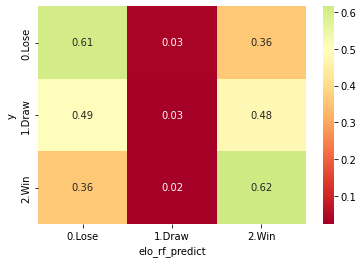

In [77]:
# watching:
pf.model_results(work_df, 'random_forest_elo', 'elo_rf_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(


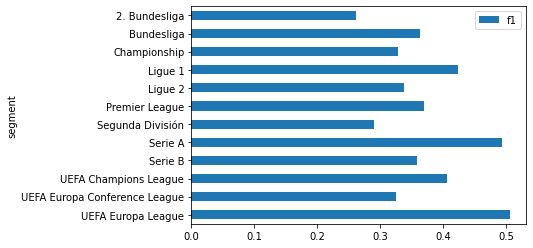

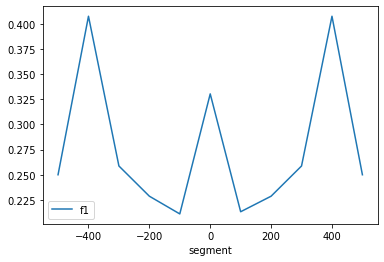

In [78]:
work_df['rating_difference'] = test_df['rating_difference'].values
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'elo_rf_predict', elo_clf, x_fields, predict_parameters)

In [79]:
hl

,size,accuracy,f1,roi,segment
0,694,0.528818,0.411808,0.516199,1
1,570,0.380702,0.315638,-0.119134,0


In [80]:
venue

,size,accuracy,f1,roi,segment
0,632,0.463608,0.370051,-0.256171,Home
1,632,0.460443,0.366029,0.673810,Away


In [81]:
fi

,feature,importance,position
0,rating_difference_normalized,1.0,0


In [82]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo


In [83]:
diffs = work_df[
 (work_df['direct_elo_predict'] != work_df['elo_rf_predict'])
]

In [84]:
len(diffs)/len(work_df)

0.3037974683544304

In [85]:
diffs['result'].value_counts()

Win     146
Lose    145
Draw     93
Name: result, dtype: int64

<AxesSubplot: >

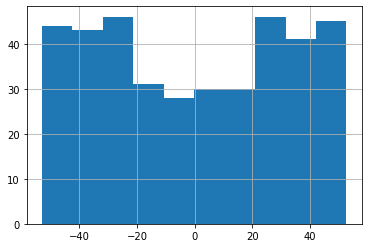

In [86]:
diffs['rating_difference'].hist()

In [87]:
diffs[[
    'team', 'opponent', 'rating_difference', 'direct_elo_predict', 'elo_rf_predict']].sort_values(by='rating_difference')

,team,opponent,rating_difference,direct_elo_predict,elo_rf_predict
28,Spal,Genoa,-52.95,Lose,Draw
630,Benevento,Ternana,-52.74,Lose,Draw
951,Bologna,Lecce,-52.73,Lose,Draw
904,Hull City,Rotherham,-52.73,Lose,Draw
434,Angers,Strasbourg,-52.17,Draw,Lose
1177,Wolves,Brentford,-52.12,Draw,Lose
175,Rodez,Guingamp,-51.95,Draw,Lose
58,Dijon,LE Havre,-51.91,Draw,Lose
976,Lille,Monaco,-51.83,Draw,Lose
133,Estac Troyes,Reims,-51.58,Draw,Lose


## Model #4: ELO + base results as Random Forest feature

In [88]:
# enriched:
venue_ohe = pd.get_dummies(train_df['venue'], prefix='is')
train_df['is_Home'] = venue_ohe['is_Home']
train_df['is_Away'] = venue_ohe['is_Away']

venue_ohe = pd.get_dummies(test_df['venue'], prefix='is')
test_df['is_Home'] = venue_ohe['is_Home']
test_df['is_Away'] = venue_ohe['is_Away']

test_df = test_df.merge(
    now_df[[
        'team', 'match_id',                    
        'wins', 'draws', 'loses', 
        'scored', 'mised',
        'is_high_league'
                 ]], 
    'left', on='team', suffixes=('', '_enreached')
                        )

In [89]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,match_id,wins,draws,loses,scored,mised,is_high_league
334,85160,Palermo,Ternana,Away,522,516,Lose,2598.50,2509.86,88.64,0.62,0.168201,0,1,903696,75,81,94,293,351,0
1254,86054,AC Milan,Torino,Away,489,503,Lose,2836.52,2608.51,228.01,0.79,0.432665,0,1,881925,227,115,115,733,508,1
736,85527,Auxerre,Nice,Home,108,84,Draw,2571.15,2612.83,-41.68,0.44,-0.079091,1,0,871615,132,118,136,465,461,1


In [90]:
train_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away
26025,14187,371195,2016-02-23,Ipswich,Hull City,Home,Lose,0,1,57,64,172,26020,0,0.0,0,1,0,0,69,48,55,222,213,England,Championship,40,2015,33,Portman Road Stadium,NaN,NaN,NaN,0,Lose,2521.92,2579.25,-57.33,0.42,-0.103083,1,0
31501,13601,18059,2016-11-05,Burton Albion,Barnsley,Home,Draw,0,0,748,747,16,31539,1,0.5,1,0,0,1,4,6,6,18,20,England,Championship,40,2016,16,Pirelli Stadium,NaN,NaN,NaN,0,Draw,2451.35,2419.47,31.88,0.55,0.055251,1,0
78345,667,720938,2022-01-09,Villarreal,Atletico Madrid,Home,Draw,2,2,533,530,400,78348,1,0.5,1,0,0,0,180,106,114,606,448,Spain,La Liga,140,2021,20,Estadio de la Cerámica,NaN,NaN,NaN,1,Draw,2696.41,2722.50,-26.09,0.46,-0.047637,1,0


In [91]:
x_fields_minus_plus = [
                        'rating_difference',
                       ]

x_fields_zero_one = [
                        'wins', 'loses', 
                    ]
x_stable = [
                'is_Home', 'is_high_league',
            ]

X_train = pf.normalize_df(train_df, x_fields_minus_plus, x_fields_zero_one, x_stable)
X_test = pf.normalize_df(test_df, x_fields_minus_plus, x_fields_zero_one, x_stable)

y_train = train_df['y'].values
y_test = test_df['y'].values

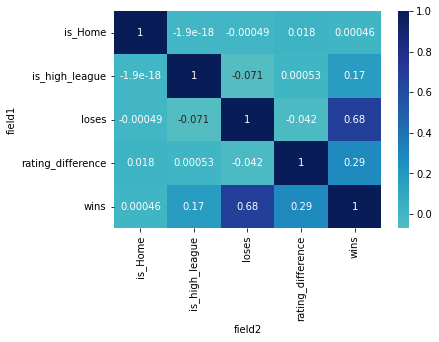

In [92]:
problems = pf.show_fields(X_train, 0.7)

In [93]:
problems

,correlation,field1,field2


In [94]:
# predicting:
real_elo_clf = RandomForestClassifier(
                    n_estimators=6,
                    max_depth=8,
                    random_state=22)
real_elo_clf.fit(X_train, y_train)
y_real_elo_rf_pred = real_elo_clf.predict(X_test)
work_df['real_elo_rf_predict'] = y_real_elo_rf_pred

,size,accuracy,f1,roi,segment,model
0,1264,0.478639,0.370284,0.262411,1,real_random_forest_elo


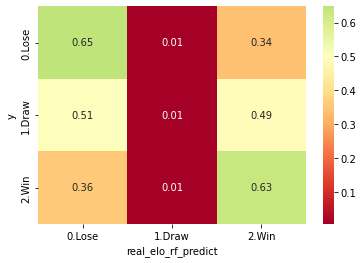

In [95]:
pf.model_results(work_df, 'real_random_forest_elo', 'real_elo_rf_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(


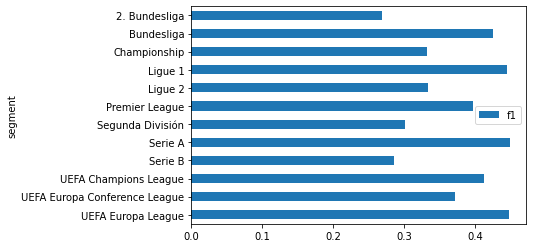

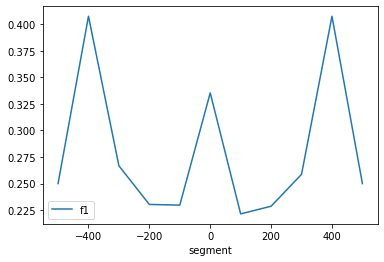

In [96]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'real_elo_rf_predict', real_elo_clf, X_train.columns, predict_parameters)

In [97]:
hl

,size,accuracy,f1,roi,segment
0,694,0.556196,0.420485,0.607082,1
1,570,0.384211,0.305863,-0.103333,0


In [98]:
venue

,size,accuracy,f1,roi,segment
0,632,0.481013,0.370137,-0.234605,Home
1,632,0.476266,0.360255,0.752814,Away


In [99]:
fi

,feature,importance,position
0,rating_difference,0.766033,0
1,is_Home,0.098386,1
2,wins,0.073120,2
3,loses,0.055840,3
4,is_high_league,0.006622,4


In [100]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo


In [101]:
work_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,date,cf1,cfdr,cf2,random_predict,revenue,global_segment,index,match_id,date_enreached,team_enreached,opponent_enreached,venue_enreached,result,team_score,opponent_score,team_id_enreached,opponent_team_id_enreached,game_number,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1_enreached,cfdr_enreached,cf2_enreached,is_high_league,y_enreached,simple_predict,direct_elo_predict,elo_rf_predict,rating_difference,rating_difference_bins,real_elo_rf_predict
579,85379,Real Betis,AS Roma,Home,543,497,Draw,2022-10-13,NaN,NaN,NaN,Draw,0.00,1,41709,946804,2022-10-13,Real Betis,AS Roma,Home,Draw,1,1,543,497,368,1,0.5,1,0,0,0,135,86,147,475,544,World,UEFA Europa League,3,2022,4,Estadio Benito Villamarín,NaN,NaN,NaN,1,Draw,Win,Draw,Win,11.27,0.0,Win
977,85797,Watford,Luton,Home,38,1359,Win,2022-10-23,2.15,3.2,3.4,Draw,2.15,1,42446,880922,2022-10-23,Watford,Luton,Home,Win,4,0,38,1359,430,3,1.0,0,0,1,1,161,93,176,585,606,England,Championship,40,2022,17,Vicarage Road,2.15,3.2,3.4,0,Win,Win,Draw,Lose,-27.07,-0.0,Win
291,85106,Jahn Regensburg,SpVgg Greuther Furth,Home,177,178,Draw,2022-10-07,NaN,NaN,NaN,Draw,0.00,1,43037,872959,2022-10-07,Jahn Regensburg,SpVgg Greuther Furth,Home,Draw,2,2,177,178,215,1,0.5,1,0,0,0,63,60,92,290,346,Germany,2. Bundesliga,79,2022,11,Jahnstadion Regensburg,NaN,NaN,NaN,0,Draw,Win,Lose,Lose,-97.83,-100.0,Lose


In [102]:
work_df[
    work_df['elo_rf_predict']!=work_df['real_elo_rf_predict']
        ][[
    'team', 'opponent', 'rating_difference', 'elo_rf_predict', 'real_elo_rf_predict'
         ]].sort_values(by='rating_difference')
   

,team,opponent,rating_difference,elo_rf_predict,real_elo_rf_predict
228,Union St. Gilloise,SC Braga,-347.01,Lose,Draw
524,Union St. Gilloise,SC Braga,-347.01,Lose,Win
1040,Union St. Gilloise,Malmo FF,-204.65,Lose,Draw
462,Arsenal,Liverpool,-139.93,Lose,Win
28,Spal,Genoa,-52.95,Draw,Lose
630,Benevento,Ternana,-52.74,Draw,Lose
904,Hull City,Rotherham,-52.73,Draw,Lose
951,Bologna,Lecce,-52.73,Draw,Lose
544,AEK Larnaca,Fenerbahce,-51.36,Lose,Win
107,Ibiza,Lugo,-50.99,Lose,Win


## Model #5: model #4 with fitting hyperparams

In [103]:
if is_hyper_search == 1:
    n_range = range(6, 20)
    d_range = range(7, 24)

    # parameter for tests
#     n_range = range(4, 7)
#     d_range = range(4, 7)

    best_n, best_depth = pf.hypeparams_fit(
                                            X_train, y_train, 
                                            X_test, test_df,
                                            n_range,
                                            d_range,
                                        )
else:
    best_n = 11
    best_depth = 17

In [104]:
best_params_elo_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
best_params_elo_clf.fit(X_train, y_train)
y_best_params = best_params_elo_clf.predict(X_test)
work_df['best_params_elo_predict'] = y_best_params

,size,accuracy,f1,roi,segment,model
0,1264,0.477057,0.418005,0.261422,1,best_params_elo


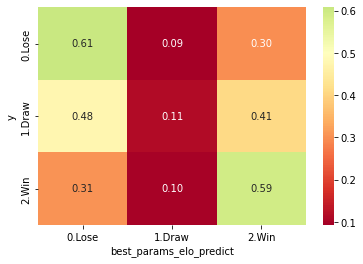

In [105]:
pf.model_results(work_df, 'best_params_elo', 'best_params_elo_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

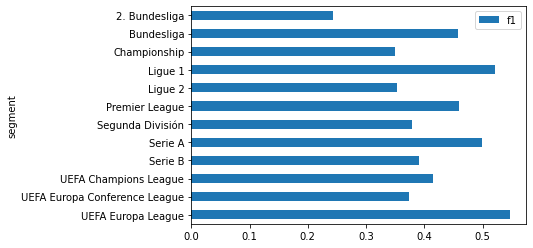

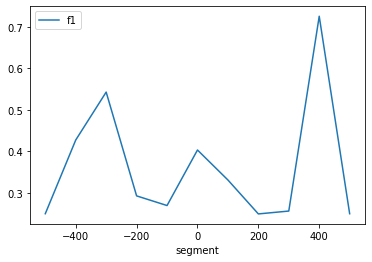

In [106]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'best_params_elo_predict', best_params_elo_clf, X_train.columns, predict_parameters)

In [107]:
hl

,size,accuracy,f1,roi,segment
0,694,0.551873,0.474871,0.600299,1
1,570,0.385965,0.346618,-0.098257,0


In [108]:
venue

,size,accuracy,f1,roi,segment
1,632,0.484177,0.418405,0.752674,Away
0,632,0.469937,0.400526,-0.221410,Home


In [109]:
fi

,feature,importance,position
0,rating_difference,0.574265,0
1,wins,0.189004,1
2,loses,0.184230,2
3,is_Home,0.041193,3
4,is_high_league,0.011307,4


In [110]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo


In [111]:
work_df.columns

Index(['id', 'team', 'opponent', 'venue', 'team_id', 'opponent_team_id', 'y',
       'date', 'cf1', 'cfdr', 'cf2', 'random_predict', 'revenue',
       'global_segment', 'index', 'match_id', 'date_enreached',
       'team_enreached', 'opponent_enreached', 'venue_enreached', 'result',
       'team_score', 'opponent_score', 'team_id_enreached',
       'opponent_team_id_enreached', 'game_number', 'points', 'score',
       'is_Draw', 'is_Lose', 'is_Win', 'is_dry_match', 'wins', 'draws',
       'loses', 'scored', 'mised', 'coutry', 'league_name', 'league_id',
       'season', 'round', 'stadium', 'cf1_enreached', 'cfdr_enreached',
       'cf2_enreached', 'is_high_league', 'y_enreached', 'simple_predict',
       'direct_elo_predict', 'elo_rf_predict', 'rating_difference',
       'rating_difference_bins', 'real_elo_rf_predict',
       'best_params_elo_predict'],
      dtype='object')

In [112]:
work_df[
    (work_df['best_params_elo_predict'] != work_df['elo_rf_predict'])
][[
    'team', 'opponent', 
    'rating_difference', 
    'wins', 'loses', 
    'venue', 'is_high_league',
    'elo_rf_predict', 'best_params_elo_predict'
    
]].sample(3)

,team,opponent,rating_difference,wins,loses,venue,is_high_league,elo_rf_predict,best_params_elo_predict
634,Paris FC,Saint Etienne,50.86,85,68,Away,0,Win,Draw
851,Blackpool,Preston,-31.20,50,90,Home,0,Lose,Win
453,Lille,Lens,-13.94,178,131,Home,1,Lose,Draw


## Model #6: personal macths

In [113]:
%%time
# personal meet
team_based_df, curr_stat_dct = pf.calc_pers_stat_df(team_based_df)
team_based_df['result_difference_peronal_meet'] = (team_based_df['wins_peronal_meet'] 
                                                        - team_based_df['loses_peronal_meet'])
team_based_df['result_difference_venue'] = (team_based_df['wins_venue'] 
                                                        - team_based_df['loses_venue'])
team_based_df['games_peronal_meet'] = (
                                         team_based_df['wins_peronal_meet'] 
                                       + team_based_df['loses_peronal_meet'] 
                                       + team_based_df['draws_peronal_meet']
                                        )

team_based_df['games_venue'] = (
                                         team_based_df['wins_venue'] 
                                       + team_based_df['loses_venue'] 
                                       + team_based_df['draws_venue']
                                        )

CPU times: user 4.4 s, sys: 16.2 ms, total: 4.41 s
Wall time: 4.41 s


In [114]:
pers_stat_df = pd.DataFrame.from_dict(curr_stat_dct, orient='index').reset_index()
pers_stat_df['team1'] = pers_stat_df['index'].apply(lambda x: x.split('-')[0])
pers_stat_df['team2'] = pers_stat_df['index'].apply(lambda x: x.split('-')[1])
pers_stat_df = pers_stat_df[1:]
pers_stat_df.columns = [
            'index', 
    
            'wins',
            'draws',
            'loses',
            'scored',
            'missed',

            'wins_home',
            'draws_home',
            'loses_home',
            'scored_home',
            'missed_home',

            'wins_away',
            'draws_away',
            'loses_away',
            'scored_away',
            'missed_away',

            'team1', 'team2'
]
pers_stat_df['results_difference'] = pers_stat_df['wins'] - pers_stat_df['loses']
pers_stat_df['games'] = pers_stat_df['wins'] + pers_stat_df['loses'] + pers_stat_df['draws']
pers_stat_df = pers_stat_df[['team1', 'team2', 'results_difference', 'games']]

team_data = team_based_df[team_based_df['season']==2021][[
    'team', 'league_name'
]].drop_duplicates()

pers_stat_df = pers_stat_df.merge(
    team_data, 
    'left', 
    left_on='team1',
    right_on='team',
)
pers_stat_df = pers_stat_df.merge(
    team_data, 
    'left', 
    left_on='team2',
    right_on='team',
    suffixes=('_team1', '_team2')
)

pers_stat_df = pers_stat_df.merge(
    now_df[['team', 'rating']], 
    'left', 
    left_on='team1',
    right_on='team',
)
pers_stat_df = pers_stat_df.merge(
    now_df[['team', 'rating']], 
    'left', 
    left_on='team2',
    right_on='team',
    suffixes=('_team1', '_team2')
)

pers_stat_df = pers_stat_df.drop(columns=[
    'team_team1',
    'team_team2',
    'team_team1',
    'team_team2',
])
pers_stat_df['rating_difference'] = pers_stat_df['rating_team1'] - pers_stat_df['rating_team2']

<ipython-input-114-b126cc93a8d0>:56: FutureWarning: Passing 'suffixes' which cause duplicate columns {'team_team1'} in the result is deprecated and will raise a MergeError in a future version.
  pers_stat_df = pers_stat_df.merge(


In [115]:
pers_stat_df.sample(3)

,team1,team2,results_difference,games,league_name_team1,league_name_team2,rating_team1,rating_team2,rating_difference
28248,Tottenham,Eintracht Frankfurt,1,2,Premier League,UEFA Europa League,2789.35,2683.03,106.32
16870,Brescia,Empoli,-3,4,Serie B,Serie A,2493.75,2569.60,-75.85
25447,Torino,Venezia,-1,2,Serie A,Serie A,2602.75,2412.42,190.33


In [116]:
def get_league_heat_map(pers_stat_df, league):
    pers_stat_pv = pers_stat_df[
        (pers_stat_df['league_name_team1'] == league) &
        (pers_stat_df['league_name_team2'] == league)
    ].pivot_table(
        index='team1', columns='team2', values='results_difference').fillna(0).reset_index()

    pers_stat_pv = pers_stat_pv.merge(
        now_df[['team', 'rating']], 
        'left', 
        left_on='team1',
        right_on='team'
    )
    pers_stat_pv = pers_stat_pv.sort_values(by='rating', ascending=False)
    pers_stat_pv = pers_stat_pv.drop(columns=['team', 'rating']).set_index('team1')

    sns.heatmap(
                pers_stat_pv, 
                cmap="RdYlGn", 
                annot=True,
    #             fmt=".0f",
                center=0,
                )

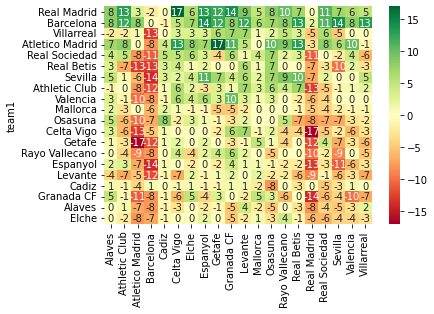

In [117]:
get_league_heat_map(pers_stat_df, 'La Liga')

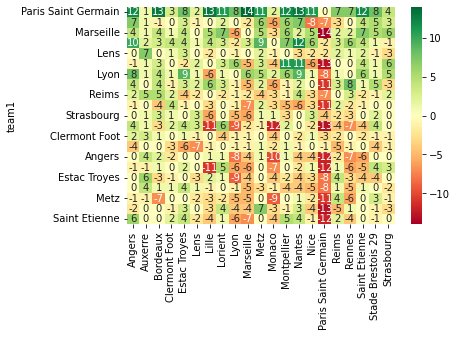

In [118]:
get_league_heat_map(pers_stat_df, 'Ligue 1')

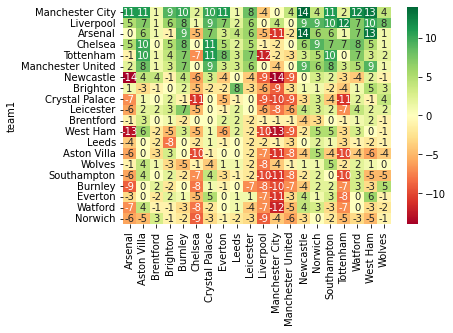

In [119]:
get_league_heat_map(pers_stat_df, 'Premier League')

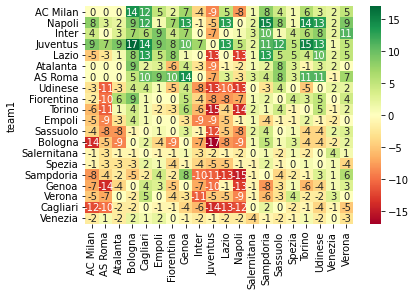

In [120]:
get_league_heat_map(pers_stat_df, 'Serie A')

In [121]:
enreached_df = pers_stat_df[
    (pers_stat_df['rating_difference'] < 0) &
    (pers_stat_df['results_difference'] > 0) &
    (pers_stat_df['league_name_team1'] == pers_stat_df['league_name_team2']) & 
    (pers_stat_df['games'] > 3)
]

In [122]:
len(enreached_df)

445

In [123]:
enreached_df.columns

Index(['team1', 'team2', 'results_difference', 'games', 'league_name_team1',
       'league_name_team2', 'rating_team1', 'rating_team2',
       'rating_difference'],
      dtype='object')

In [124]:
enreached_df.sort_values(by='results_difference', ascending=False)[[
    'team1', 'team2', 'games', 'results_difference', 'rating_difference'
]].drop_duplicates()[0:10]

,team1,team2,games,results_difference,rating_difference
2819,Borussia Dortmund,SC Freiburg,19,12,-31.42
3688,Sevilla,Real Betis,18,10,-36.71
4510,Borussia Dortmund,VfL Wolfsburg,21,10,-9.90
3994,Juventus,AC Milan,21,9,-97.26
8690,Auxerre,Sochaux,16,9,-10.71
2504,Cardiff,Nottingham Forest,16,9,-162.13
1643,Borussia Dortmund,Eintracht Frankfurt,21,8,-6.26
1800,Borussia Dortmund,Borussia Monchengladbach,21,8,-20.13
4626,Nice,Rennes,20,8,-121.88
3593,Napoli,AC Milan,21,8,-20.37


In [125]:
team_based_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue
19575,27969,186243,2015-04-15,Lyon,Bastia,Home,Win,2,0,80,1305,116,19574,3,1.0,0,0,1,1,60,27,29,189,115,France,Ligue 1,61,2014,32,Stade de Gerland (Lyon),NaN,NaN,NaN,1,Win,2760.68,2497.55,263.13,0.82,4,1,1,15,8,3,0,0,11,3,3,3,6,3
46058,12703,11933,2018-04-28,Preston,Sheffield Utd,Away,Win,1,0,59,62,137,46089,3,1.0,0,0,1,1,49,47,41,164,153,England,Championship,40,2017,45,Bramall Lane,NaN,NaN,NaN,0,Win,2532.46,2550.17,-17.71,0.47,2,0,0,2,0,1,0,0,1,0,2,1,2,1
280,10077,193437,2012-08-18,Arsenal,Sunderland,Home,Draw,0,0,42,746,1,304,1,0.5,1,0,0,1,0,1,0,0,0,England,Premier League,39,2012,1,Emirates Stadium (London),NaN,NaN,NaN,1,Draw,2632.81,2443.19,189.62,0.75,0,1,0,0,0,0,1,0,0,0,0,0,1,1


In [126]:
pers_stat_df.groupby('league_name_team1').mean()[['games']]

,games
league_name_team1,
2. Bundesliga,7.561850
Bundesliga,8.144254
Championship,7.773525
La Liga,7.847626
Ligue 1,7.869504
Ligue 2,6.551758
Premier League,7.913455
Segunda División,5.176089
Serie A,7.668353


In [127]:
train_df, curr_stat_dct = pf.calc_pers_stat_df(train_df)

In [128]:
def spl(txt):
    
    txt = txt.replace(' ', '')
    txt = txt[1:-1]
    lst = txt.split(',')

    res_lst = []
    for l in lst:
        res_lst.append(int(l))
    
    return res_lst

test_df['caption'] = test_df['team'] + '-' + test_df['opponent']

mask = '[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]'
match_stat_ser = test_df['caption'].map(curr_stat_dct).fillna(str(mask))
match_stat_ser = match_stat_ser.apply(lambda x: spl(str(x)))

pers_stat = pd.DataFrame.from_dict(dict(zip(match_stat_ser.index, match_stat_ser.values))).T
pers_stat['id'] = test_df['id'].values
pers_stat_df_venue = pf.pes_stat_venue(pers_stat)

test_df = test_df.merge(pers_stat_df_venue, 'left', on=['id', 'venue'], suffixes=('', '_personal_meet'))

In [129]:
x_fields_minus_plus = [
                        'rating_difference',
#                         'new_value',
                        'result_difference_peronal_meet'#, 'result_difference_venue'
                       ]

x_fields_zero_one = [
                        'wins', 'loses', 
                    ]
x_stable = [
                'is_Home', 'is_high_league',
            ]

X_train = pf.normalize_df(train_df, x_fields_minus_plus, x_fields_zero_one, x_stable)
X_test = pf.normalize_df(test_df, x_fields_minus_plus, x_fields_zero_one, x_stable)

y_train = train_df['y'].values
y_test = test_df['y'].values

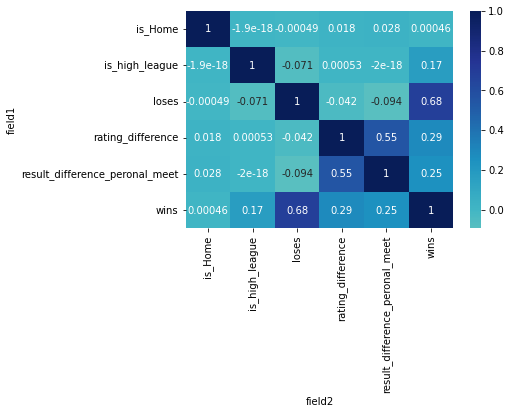

In [130]:
problems = pf.show_fields(X_train, 0.7)

In [131]:
problems

,correlation,field1,field2


,size,accuracy,f1,roi,segment,model
0,1264,0.427215,0.408253,0.149049,1,with_pers_meets


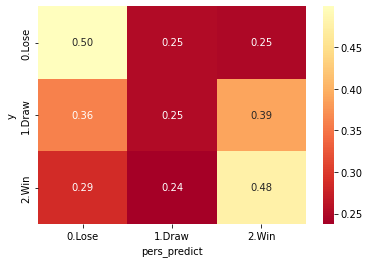

In [132]:
pers_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
pers_clf.fit(X_train, y_train)
y_pers = pers_clf.predict(X_test)
work_df['pers_predict'] = y_pers

pf.model_results(work_df, 'with_pers_meets', 'pers_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

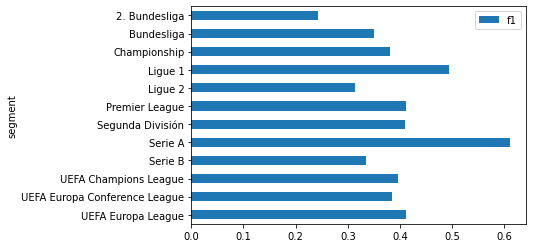

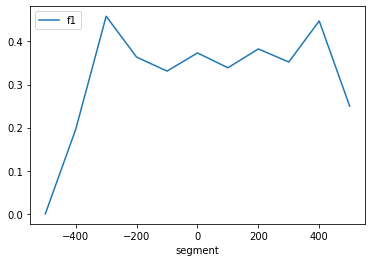

In [133]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'pers_predict', pers_clf, X_train.columns, predict_parameters)

In [134]:
hl

,size,accuracy,f1,roi,segment
0,694,0.484150,0.445169,0.426829,1
1,570,0.357895,0.353788,-0.164204,0


In [135]:
venue

,size,accuracy,f1,roi,segment
1,632,0.430380,0.402318,0.583002,Away
0,632,0.424051,0.396854,-0.287315,Home


In [136]:
fi

,feature,importance,position
0,result_difference_peronal_meet,0.337494,0
1,rating_difference,0.294335,1
2,wins,0.167301,2
3,loses,0.164417,3
4,is_Home,0.025581,4
5,is_high_league,0.010872,5


In [137]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo
6,1264,0.427215,0.408253,0.149049,with_pers_meets


In [138]:
work_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,date,cf1,cfdr,cf2,random_predict,revenue,global_segment,index,match_id,date_enreached,team_enreached,opponent_enreached,venue_enreached,result,team_score,opponent_score,team_id_enreached,opponent_team_id_enreached,game_number,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1_enreached,cfdr_enreached,cf2_enreached,is_high_league,y_enreached,simple_predict,direct_elo_predict,elo_rf_predict,rating_difference,rating_difference_bins,real_elo_rf_predict,best_params_elo_predict,pers_predict
771,85588,Eibar,Sporting Gijon,Away,545,731,Lose,2022-10-17,NaN,NaN,NaN,Draw,0.0,1,41360,878437,2022-10-17,Eibar,Sporting Gijon,Away,Lose,0,2,545,731,321,0,0.0,0,1,0,0,106,85,130,373,433,Spain,Segunda División,141,2022,11,Estadio Municipal El Molinón,NaN,NaN,NaN,0,Lose,Win,Win,Win,101.24,100.0,Win,Win,Win
1014,85825,AC Milan,Dinamo Zagreb,Away,489,620,Win,2022-10-25,NaN,NaN,NaN,Draw,0.0,1,41598,946915,2022-10-25,AC Milan,Dinamo Zagreb,Away,Win,4,0,489,620,452,3,1.0,0,0,1,1,224,114,114,724,504,World,UEFA Champions League,2,2022,5,Stadion Maksimir,NaN,NaN,NaN,1,Win,Win,Win,Win,205.62,200.0,Win,Win,Draw
392,85124,Borussia Dortmund,Bayern Munich,Home,165,157,Draw,2022-10-08,4.33,4.6,1.63,Draw,0.0,1,42877,871236,2022-10-08,Borussia Dortmund,Bayern Munich,Home,Draw,2,2,165,157,453,1,0.5,1,0,0,0,254,86,113,961,574,Germany,Bundesliga,78,2022,9,Signal-Iduna-Park,4.33,4.6,1.63,1,Draw,Win,Lose,Lose,-148.32,-100.0,Lose,Lose,Lose


## Model #7 model #6 with hyperparams

In [139]:
%%time
if is_hyper_search == 1:
    n_range = range(6, 20)
    d_range = range(7, 24)

    # parameter for tests
#     n_range = range(4, 7)
#     d_range = range(4, 7)

    best_n, best_depth = pf.hypeparams_fit(
                                            X_train, y_train, 
                                            X_test, test_df,
                                            n_range,
                                            d_range,
                                        )
else:
    best_n = 10
    best_depth = 16

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [140]:
best_pers_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
best_pers_clf.fit(X_train, y_train)
y_best_pers = best_pers_clf.predict(X_test)
work_df['best_pers_predict'] = y_best_pers

,size,accuracy,f1,roi,segment,model
0,1264,0.451741,0.433574,0.194575,1,pers_meets_hyperparams


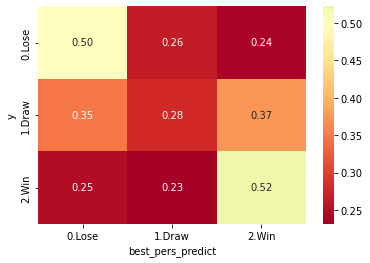

In [141]:
pf.model_results(work_df, 'pers_meets_hyperparams', 'best_pers_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

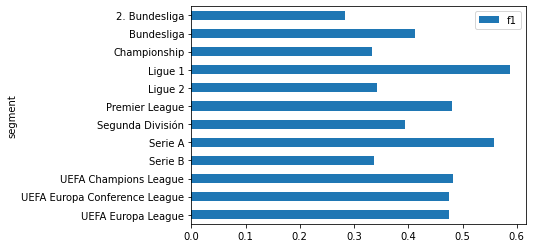

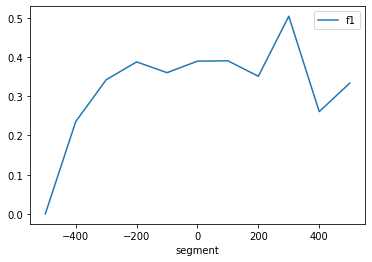

In [142]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'best_pers_predict', best_pers_clf, X_train.columns, predict_parameters)

In [143]:
hl

,size,accuracy,f1,roi,segment
0,694,0.528818,0.502112,0.535805,1
1,570,0.357895,0.348624,-0.177613,0


In [144]:
venue

,size,accuracy,f1,roi,segment
0,632,0.454114,0.426448,-0.228015,Home
1,632,0.449367,0.423822,0.615574,Away


In [145]:
fi

,feature,importance,position
0,result_difference_peronal_meet,0.374820,0
1,rating_difference,0.277942,1
2,wins,0.156699,2
3,loses,0.151733,3
4,is_Home,0.028115,4
5,is_high_league,0.010691,5


In [146]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo
6,1264,0.427215,0.408253,0.149049,with_pers_meets
7,1264,0.451741,0.433574,0.194575,pers_meets_hyperparams


## Model #7 Using detailed match statistics

In [147]:
# additional match statistics
team_based_df = team_based_df.merge(
                match_stat, 'left', on=['match_id', 'team'], suffixes=('', '_stat')
                                    ).fillna(0)

team_based_df['shots_accuracy'] = (team_based_df['shots_on_goal'] / team_based_df['total_shots']).fillna(0)
team_based_df_stat = team_based_df[team_based_df['ball_possession']>0]
print(len(team_based_df_stat)/len(team_based_df))

0.6483534210586961


In [148]:
def get_stat_df(df, fields, method):
    stat_df = df.groupby(fields).agg(
        games = ('match_id', 'count'),
        points = ('points', method),
        wins = ('is_Win', method),
        draws = ('is_Draw', method),
        loses = ('is_Lose', method),
        scored = ('team_score', method),
        mised = ('opponent_score', method),
        dry = ('is_dry_match', method),
        shots = ('total_shots', method),
        shots_on_goal = ('shots_on_goal', method),
        fouls = ('fouls', method),
        ball_possession = ('ball_possession', 'mean'),
        passes = ('total_passes', method),
        passes_accurate = ('passes_accurate', method),
                                        ).sort_values('points', ascending=False)
    
    stat_df['score_diff'] = stat_df['scored'] - stat_df['mised'] 
    stat_df['goals_per_game'] = np.round(stat_df['scored'] / stat_df['games'], 2)
    stat_df['win_rate'] = np.round(stat_df['wins'] / stat_df['games'] , 2)
    stat_df['peacefullaty'] = np.round(stat_df['draws'] / stat_df['games'] , 2)
    stat_df['dryality'] = np.round(stat_df['dry'] / stat_df['games'] , 2)
    
    stat_df['shots_accuracy'] = np.round(stat_df['shots_on_goal'] / stat_df['shots'],2)
    stat_df['passes_accuracy'] = np.round(stat_df['passes_accurate'] / stat_df['passes'],2)
    
    rating_df = df.loc[df.groupby(fields)['date'].idxmax()].set_index(fields)[['rating']].reset_index()
    
    stat_df = stat_df.merge(rating_df, 'left', on=fields).set_index(fields)
    
    stat_df=stat_df[[
        'games', 'points', 
        'rating', 
        'wins', 'draws', 'loses',
        'scored', 'mised', 'score_diff', 'goals_per_game',
        'dry', 'dryality',
        'win_rate', 'peacefullaty',
        'shots', 'shots_on_goal', 'shots_accuracy',
        'ball_possession', 
        'passes', 'passes_accurate','passes_accuracy',
        'fouls'
        
    ]].reset_index()
    
    return stat_df

In [149]:
get_stat_df(
            team_based_df[
                (team_based_df['league_name'] == 'La Liga') &
                (team_based_df['season'] <= 2015)
                        ],
            ['team'],
            'sum'
           ).columns

Index(['team', 'games', 'points', 'rating', 'wins', 'draws', 'loses', 'scored',
       'mised', 'score_diff', 'goals_per_game', 'dry', 'dryality', 'win_rate',
       'peacefullaty', 'shots', 'shots_on_goal', 'shots_accuracy',
       'ball_possession', 'passes', 'passes_accurate', 'passes_accuracy',
       'fouls'],
      dtype='object')

In [150]:
get_stat_df(
            team_based_df[
                (team_based_df['league_name'] == 'La Liga') &
                (team_based_df['season'] == 2016) &
                (team_based_df['venue'] == 'Home')
                        ],
            ['team'],
            'sum'
           )

,team,games,points,rating,wins,draws,loses,scored,mised,score_diff,goals_per_game,dry,dryality,win_rate,peacefullaty,shots,shots_on_goal,shots_accuracy,ball_possession,passes,passes_accurate,passes_accuracy,fouls
0,Barcelona,19,48,2867.38,15,3,1,64,17,47,3.37,7,0.37,0.79,0.16,370.0,149.0,0.40,0.673158,12292.0,10802.0,0.88,207.0
1,Sevilla,19,46,2650.96,14,4,1,39,16,23,2.05,8,0.42,0.74,0.21,276.0,115.0,0.42,0.606842,10233.0,8504.0,0.83,307.0
2,Real Madrid,19,46,2869.23,14,4,1,48,20,28,2.53,5,0.26,0.74,0.21,349.0,133.0,0.38,0.577895,10280.0,8972.0,0.87,213.0
3,Atletico Madrid,19,44,2798.48,14,2,3,40,14,26,2.11,10,0.53,0.74,0.11,310.0,113.0,0.36,0.506316,9058.0,7340.0,0.81,264.0
4,Athletic Club,19,43,2604.36,13,4,2,36,18,18,1.89,4,0.21,0.68,0.21,263.0,109.0,0.41,0.522632,8260.0,6368.0,0.77,265.0
5,Villarreal,19,37,2627.40,11,4,4,35,18,17,1.84,7,0.37,0.58,0.21,260.0,100.0,0.38,0.521579,9259.0,7612.0,0.82,254.0
6,Real Sociedad,19,35,2618.61,10,5,4,30,24,6,1.58,5,0.26,0.53,0.26,280.0,90.0,0.32,0.581579,9712.0,7861.0,0.81,262.0
7,Eibar,19,33,2474.26,10,3,6,29,21,8,1.53,7,0.37,0.53,0.16,242.0,89.0,0.37,0.506842,7709.0,5583.0,0.72,248.0
8,Las Palmas,19,33,2463.96,9,6,4,33,25,8,1.74,5,0.26,0.47,0.32,241.0,111.0,0.46,0.597368,10778.0,9205.0,0.85,238.0
9,Malaga,19,32,2571.15,10,2,7,32,25,7,1.68,4,0.21,0.53,0.11,284.0,98.0,0.35,0.498421,7920.0,6091.0,0.77,263.0


In [151]:
get_stat_df(
            team_based_df[
                (team_based_df['league_name'] == 'La Liga') &
                (team_based_df['season'] == 2016) &
                (team_based_df['venue'] == 'Home')
                        ],
            ['team'],
            'mean'
           )

,team,games,points,rating,wins,draws,loses,scored,mised,score_diff,goals_per_game,dry,dryality,win_rate,peacefullaty,shots,shots_on_goal,shots_accuracy,ball_possession,passes,passes_accurate,passes_accuracy,fouls
0,Barcelona,19,2.526316,2867.38,0.789474,0.157895,0.052632,3.368421,0.894737,2.473684,0.18,0.368421,0.02,0.04,0.01,19.473684,7.842105,0.40,0.673158,646.947368,568.526316,0.88,10.894737
1,Sevilla,19,2.421053,2650.96,0.736842,0.210526,0.052632,2.052632,0.842105,1.210526,0.11,0.421053,0.02,0.04,0.01,14.526316,6.052632,0.42,0.606842,538.578947,447.578947,0.83,16.157895
2,Real Madrid,19,2.421053,2869.23,0.736842,0.210526,0.052632,2.526316,1.052632,1.473684,0.13,0.263158,0.01,0.04,0.01,18.368421,7.000000,0.38,0.577895,541.052632,472.210526,0.87,11.210526
3,Atletico Madrid,19,2.315789,2798.48,0.736842,0.105263,0.157895,2.105263,0.736842,1.368421,0.11,0.526316,0.03,0.04,0.01,16.315789,5.947368,0.36,0.506316,476.736842,386.315789,0.81,13.894737
4,Athletic Club,19,2.263158,2604.36,0.684211,0.210526,0.105263,1.894737,0.947368,0.947368,0.10,0.210526,0.01,0.04,0.01,13.842105,5.736842,0.41,0.522632,434.736842,335.157895,0.77,13.947368
5,Villarreal,19,1.947368,2627.40,0.578947,0.210526,0.210526,1.842105,0.947368,0.894737,0.10,0.368421,0.02,0.03,0.01,13.684211,5.263158,0.38,0.521579,487.315789,400.631579,0.82,13.368421
6,Real Sociedad,19,1.842105,2618.61,0.526316,0.263158,0.210526,1.578947,1.263158,0.315789,0.08,0.263158,0.01,0.03,0.01,14.736842,4.736842,0.32,0.581579,511.157895,413.736842,0.81,13.789474
7,Eibar,19,1.736842,2474.26,0.526316,0.157895,0.315789,1.526316,1.105263,0.421053,0.08,0.368421,0.02,0.03,0.01,12.736842,4.684211,0.37,0.506842,405.736842,293.842105,0.72,13.052632
8,Las Palmas,19,1.736842,2463.96,0.473684,0.315789,0.210526,1.736842,1.315789,0.421053,0.09,0.263158,0.01,0.02,0.02,12.684211,5.842105,0.46,0.597368,567.263158,484.473684,0.85,12.526316
9,Malaga,19,1.684211,2571.15,0.526316,0.105263,0.368421,1.684211,1.315789,0.368421,0.09,0.210526,0.01,0.03,0.01,14.947368,5.157895,0.35,0.498421,416.842105,320.578947,0.77,13.842105


In [152]:
len(team_based_df_stat)

56268

In [153]:
team_based_df_stat.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy
41840,2229,9748,2017-12-04,Girona,Alaves,Home,Lose,2,3,547,542,56,41843,0,0.0,0,1,0,0,24,15,17,83,67,Spain,La Liga,140,2017,14,Estadi Montilivi,0.0,0.0,0.0,1,Lose,2570.71,2477.08,93.63,0.63,0,0,1,2,3,0,0,1,2,3,-1,-1,1,1,3.0,5.0,11.0,3.0,6.0,5.0,8.0,6.0,1.0,0.56,1.0,0.0,1.0,506.0,399.0,0.79,Home,2022-09-15 09:21:44.551013,0.272727
46100,8208,11563,2018-04-28,Crystal Palace,Leicester,Home,Win,5,0,52,46,236,46055,3,1.0,0,0,1,1,78,56,102,285,329,England,Premier League,39,2017,36,Selhurst Park,0.0,0.0,0.0,1,Win,2541.77,2594.77,-53.00,0.42,5,2,3,18,10,2,2,1,11,5,2,1,10,5,9.0,4.0,15.0,2.0,13.0,2.0,11.0,8.0,1.0,0.49,1.0,0.0,0.0,403.0,338.0,0.84,Home,2022-09-29 04:44:25.080818,0.600000
23086,36353,540910,2015-10-22,Slovan Liberec,Groningen,Home,Draw,1,1,782,202,14,23088,1,0.5,1,0,0,0,8,1,5,17,12,World,UEFA Europa League,3,2015,3,Stadion u Nisy,0.0,0.0,0.0,1,Draw,2503.69,2512.86,-9.17,0.49,0,1,0,1,1,0,1,0,1,1,0,0,1,1,7.0,10.0,23.0,6.0,12.0,11.0,0.0,5.0,0.0,0.48,2.0,0.0,4.0,339.0,248.0,0.73,Home,2022-09-27 07:56:39.179908,0.304348


In [154]:
team_based_df_stat.groupby('league_name')[['total_shots']].describe()

total_shots                                  \
                                    count       mean       std  min   25%   
league_name                                                                 
2. Bundesliga                      3790.0  13.312137  4.723714  0.0  10.0   
Bundesliga                         4570.0  12.868928  5.113089  0.0   9.0   
Championship                       8154.0  12.246627  4.728298  0.0   9.0   
La Liga                            5420.0  11.715683  4.733902  0.0   8.0   
Ligue 1                            5422.0  12.052564  4.716458  0.0   9.0   
Ligue 2                            4432.0  11.266697  4.438470  0.0   8.0   
Premier League                     5616.0  12.552885  5.445305  0.0   9.0   
Segunda División                   5972.0  11.313965  4.389401  0.0   8.0   
Serie A                            5618.0  13.244037  5.523582  0.0   9.0   
Serie B                            1868.0  12.881156  4.883189  1.0   9.0   
UEFA Champions League              2104.0  12.810361  5.725340  0.0   9.0   
UEFA Europa Conference League       550.0  12.058182  5.328573  0.0   8.0   
UEFA Europa League                 2752.0  12.207485  5.273216  0.0   8.0   

                                                 
                                50%   75%   max  
league_name                                      
2. Bundesliga                  13.0  16.0  35.0  
Bundesliga                     12.0  16.0  37.0  
Championship                   12.0  15.0  36.0  
La Liga                        11.0  15.0  36.0  
Ligue 1                        12.0  15.0  34.0  
Ligue 2                        11.0  14.0  36.0  
Premier League                 12.0  16.0  38.0  
Segunda División               11.0  14.0  31.0  
Serie A                        13.0  17.0  47.0  
Serie B                        12.0  16.0  31.0  
UEFA Champions League          12.0  16.0  37.0  
UEFA Europa Conference League  12.0  15.0  32.0  
UEFA Europa League             12.0  15.0  36.0

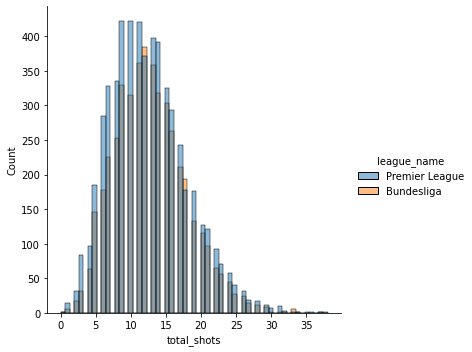

In [155]:
sns.displot(
            data=team_based_df_stat[team_based_df_stat['league_name'].isin([
                'Premier League', 'Bundesliga'#, 'La Liga', 'Serie A'
            ])]
            , x="total_shots", hue="league_name")

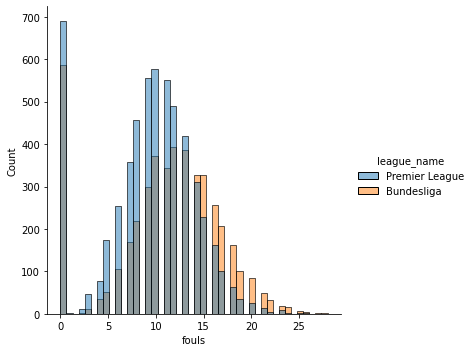

In [156]:
sns.displot(
            data=team_based_df_stat[team_based_df_stat['league_name'].isin([
                'Premier League', 'Bundesliga'#, 'La Liga', 'Serie A'
            ])]
            , x="fouls", hue="league_name")

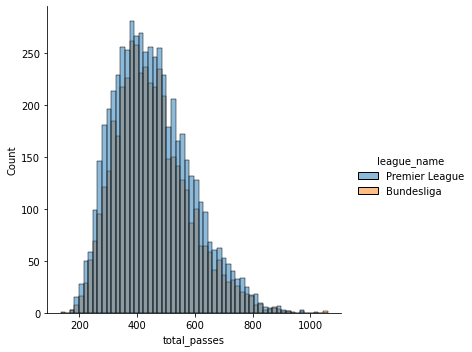

In [157]:
sns.displot(
            data=team_based_df_stat[team_based_df_stat['league_name'].isin([
                'Premier League', 'Bundesliga'#, 'La Liga', 'Serie A'
            ])]
            , x="total_passes", hue="league_name")

<ipython-input-158-b93533d92849>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_based_df_stat['team_score'] = team_based_df_stat['team_score'].astype('int')


<AxesSubplot: xlabel='total_shots', ylabel='team_score'>

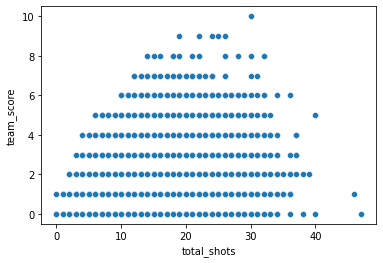

In [158]:
# sns.scatterplot(data=team_based_df_stat, x='team_score', y='score')
# sns.scatterplot(data=team_based_df_stat, x='total_shots', y='team_score')
# sns.scatterplot(data=team_based_df_stat, x='total_shots', y='shots_accuracy')
team_based_df_stat['team_score'] = team_based_df_stat['team_score'].astype('int')
sns.scatterplot(data=team_based_df_stat, x='total_shots', y='team_score')

In [159]:
team_based_df_stat[0:3]

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy
17777,9544,192904,2015-01-31,Manchester City,Chelsea,Away,Draw,1,1,50,49,119,17754,1,0.5,1,0,0,0,71,25,23,249,127,England,Premier League,39,2014,23,Stamford Bridge,0.0,0.0,0.0,1,Draw,2746.17,2776.72,-30.55,0.46,1,3,2,5,5,0,2,1,2,3,-1,-1,6,3,5.0,4.0,9.0,0.0,8.0,1.0,14.0,8.0,3.0,0.58,2.0,0.0,1.0,544.0,436.0,0.80,Away,2022-09-29 04:24:20.743615,0.555556
17790,9544,192904,2015-01-31,Chelsea,Manchester City,Home,Draw,1,1,49,50,123,17731,1,0.5,1,0,0,0,76,26,21,250,109,England,Premier League,39,2014,23,Stamford Bridge,0.0,0.0,0.0,1,Draw,2775.84,2747.05,28.79,0.54,2,3,1,5,5,1,2,0,3,2,1,1,6,3,2.0,1.0,3.0,0.0,2.0,1.0,12.0,1.0,2.0,0.42,0.0,0.0,4.0,416.0,296.0,0.71,Home,2022-09-29 04:24:20.743615,0.666667
17817,9545,192905,2015-02-01,Aston Villa,Arsenal,Away,Lose,0,5,66,42,99,17816,0,0.0,0,1,0,0,25,26,48,97,160,England,Premier League,39,2014,23,Emirates Stadium,0.0,0.0,0.0,1,Lose,2423.10,2674.32,-251.22,0.19,1,1,4,5,13,1,0,2,4,8,-3,-1,6,3,2.0,5.0,9.0,2.0,4.0,5.0,10.0,7.0,0.0,0.52,2.0,0.0,3.0,549.0,464.0,0.85,Away,2022-09-29 04:42:50.723683,0.222222


In [160]:
team_based_df_stat[(team_based_df_stat['team_score']==1)&(team_based_df_stat['total_shots']>=40)]

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy
82131,16387,731951,2022-05-14,AS Roma,Venezia,Home,Draw,1,1,497,517,465,82087,1,0.5,1,0,0,0,251,108,106,857,546,Italy,Serie A,135,2021,37,Stadio Olimpico,0.0,0.0,0.0,1,Draw,2679.21,2447.91,231.3,0.79,0,1,1,3,4,0,1,0,1,1,-1,0,2,1,16.0,12.0,46.0,18.0,21.0,25.0,11.0,20.0,0.0,0.69,2.0,0.0,1.0,548.0,473.0,0.86,Home,2022-09-28 09:21:33.897594,0.347826


In [161]:
# very short df for tests
sample_df = team_based_df[
    (team_based_df['team'] == 'Malaga') &
    (team_based_df['opponent'] == 'Sevilla')
]

In [162]:
sample_df['shots_accuracy'] = sample_df['shots_accuracy'].interpolate(method='nearest')

<ipython-input-162-f997420cd412>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['shots_accuracy'] = sample_df['shots_accuracy'].interpolate(method='nearest')


In [163]:
# sample_df

In [164]:
sample_df['moving_pass'] = sample_df.groupby('team_id')[
    'total_passes'].transform(lambda x: x.rolling(4, 1).mean())

<ipython-input-164-d9dce18ef205>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df['moving_pass'] = sample_df.groupby('team_id')[


In [165]:
sample_df[['team_id', 'total_passes', 'moving_pass']]

,team_id,total_passes,moving_pass
3186,535,0.0,0.00
6319,535,0.0,0.00
7353,535,0.0,0.00
10463,535,0.0,0.00
17575,535,0.0,0.00
20517,535,0.0,0.00
21563,535,374.0,93.50
25098,535,341.0,178.75
32842,535,380.0,273.75
36718,535,296.0,347.75


In [166]:
work_lst = [
    'wins', 'draws', 'loses', 
    'scored','mised', 
    'score_diff',
    'dry',
    'shots', 'shots_on_goal', 'shots_accuracy',
    'ball_possession', 'passes', 'passes_accurate', 'passes_accuracy',
    'fouls'
]

In [167]:
# сплит
# train: ma полей по списку 
# mean by seson leages
# merge by zeros
# test:
# fresh ma by team_id

In [168]:
train_df = train_df.merge(
                match_stat, 'left', on=['match_id', 'team'], suffixes=('', '_stat')
                                    ).fillna(0)

train_df['shots_accuracy'] = (train_df['shots_on_goal'] / train_df['total_shots']).fillna(0)

In [169]:
ma_list = [
    'shots_on_goal', 'fouls',
    'offsides', 'ball_possession'
]
ma_list_ma = []

In [170]:
for col in ma_list:
    train_df[col+'_ma'] = np.where(
                        train_df['game_number'] <= 10, train_df[col],
                        train_df.groupby('team_id')[col].transform(lambda x: x.rolling(8, 1).mean())
                                  )
    ma_list_ma.append(col+'_ma')

fresh_game_num = train_df.groupby('team_id').max()['game_number'].reset_index()
fresh_game_num.columns = ['team_id', 'last_game']
train_df = train_df.merge(fresh_game_num, 'left', on='team_id')
fresh_df = train_df[
    train_df['game_number'] == train_df['last_game']
                    ]
ma_list_ma.append('team_id')
stat_dct = fresh_df[ma_list_ma]

<ipython-input-170-4a37b5c2aec0>:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  fresh_game_num = train_df.groupby('team_id').max()['game_number'].reset_index()


In [171]:
stat_dct.sample(3)

,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,team_id
82510,0.000,0.000,0.000,0.00000,4194
82782,0.375,2.250,0.375,0.06875,661
37275,4.625,16.625,2.000,0.49875,786


In [172]:
test_df = test_df.merge(
                stat_dct, 'left', on=['team_id'], suffixes=('', '_stat')
                                    ).fillna(0)

In [173]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,match_id,wins,draws,loses,scored,mised,is_high_league,caption,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma
72,84832,Newcastle,Fulham,Away,34,36,Win,2664.41,2531.99,132.42,0.68,0.251276,0,1,868101,142,91,170,495,583,1,Newcastle-Fulham,4,2,4,11,8,2,0,3,7,4,0,-1,10,5,5.500,11.00,2.000,0.50250
395,85129,Tottenham,Brighton,Away,47,51,Win,2794.76,2705.34,89.42,0.63,0.169681,0,1,868103,259,95,124,859,541,1,Tottenham-Brighton,6,1,3,12,9,2,1,2,5,6,3,0,10,5,5.875,10.75,1.875,0.48000
675,85435,LE Havre,Rodez,Away,111,1301,Draw,2515.73,2452.74,62.99,0.59,0.119528,0,1,872016,151,124,111,471,389,0,LE Havre-Rodez,1,4,0,4,3,1,2,0,3,2,1,1,5,3,4.625,16.50,2.250,0.60625


In [174]:
x_fields_minus_plus = [
                        'rating_difference',
                        'result_difference_peronal_meet'#, 'result_difference_venue'
                       ]

x_fields_zero_one = [
                        'wins', 'loses', 
                        'shots_on_goal_ma',
                        'fouls_ma',
                        'offsides_ma', 'ball_possession_ma',
                    ]
x_stable = [
                'is_Home', 'is_high_league',
            ]


In [175]:
X_train = pf.normalize_df(train_df, x_fields_minus_plus, x_fields_zero_one, x_stable)
X_test = pf.normalize_df(test_df, x_fields_minus_plus, x_fields_zero_one, x_stable)

y_train = train_df['y'].values
y_test = test_df['y'].values

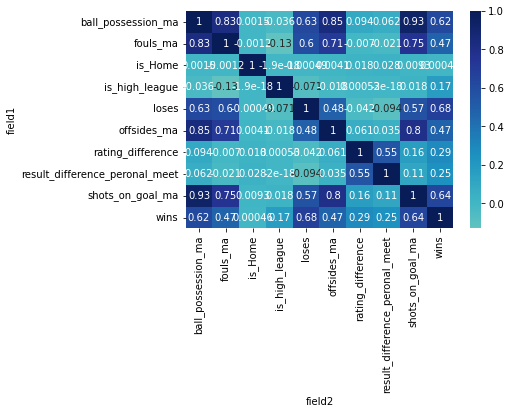

In [176]:
problems = pf.show_fields(X_train, 0.75)

In [177]:
problems

,correlation,field1,field2
45,0.751272,shots_on_goal_ma,fouls_ma
46,0.795156,shots_on_goal_ma,offsides_ma
47,0.930544,shots_on_goal_ma,ball_possession_ma
54,0.751272,fouls_ma,shots_on_goal_ma
57,0.827109,fouls_ma,ball_possession_ma
64,0.795156,offsides_ma,shots_on_goal_ma
67,0.845897,offsides_ma,ball_possession_ma
74,0.930544,ball_possession_ma,shots_on_goal_ma
75,0.827109,ball_possession_ma,fouls_ma
76,0.845897,ball_possession_ma,offsides_ma


In [178]:
stat_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
stat_clf.fit(X_train, y_train)
y_stat = stat_clf.predict(X_test)
work_df['match_stat_predict'] = y_stat

,size,accuracy,f1,roi,segment,model
0,1264,0.394778,0.383167,0.020932,1,with_match_stat


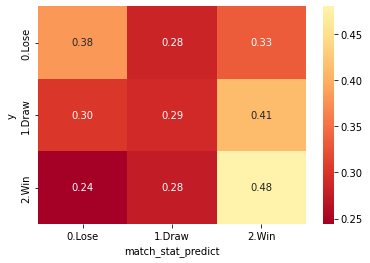

In [179]:
pf.model_results(work_df, 'with_match_stat', 'match_stat_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

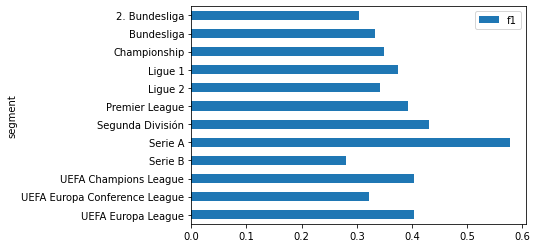

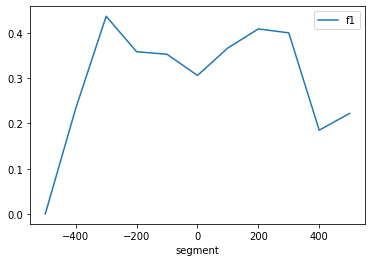

In [180]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'match_stat_predict', stat_clf, X_train.columns, predict_parameters)

In [181]:
hl

,size,accuracy,f1,roi,segment
0,694,0.425072,0.406944,0.231852,1
1,570,0.357895,0.352114,-0.224511,0


In [182]:
venue

,size,accuracy,f1,roi,segment
1,632,0.400316,0.386488,0.394067,Away
0,632,0.389241,0.364488,-0.350829,Home


In [183]:
fi

,feature,importance,position
0,result_difference_peronal_meet,0.343194,0
1,rating_difference,0.218092,1
2,wins,0.098072,2
3,loses,0.094897,3
4,ball_possession_ma,0.061945,4
5,shots_on_goal_ma,0.050438,5
6,fouls_ma,0.050232,6
7,offsides_ma,0.044702,7
8,is_Home,0.027533,8
9,is_high_league,0.010894,9


In [184]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo
6,1264,0.427215,0.408253,0.149049,with_pers_meets
7,1264,0.451741,0.433574,0.194575,pers_meets_hyperparams
8,1264,0.394778,0.383167,0.020932,with_match_stat


# Model #9: Personal rating

In [185]:
team_based_df = team_based_df.merge(
                indiv_mark, 'left', on=['match_id', 'team_id'], suffixes=('', '_indiv')
                                    ).fillna(0)

In [186]:
team_based_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,avg_mark
77424,38490,719823,2021-12-03,Nimes,Rodez,Away,Lose,0,1,92,1301,349,77406,0,0.0,0,1,0,0,127,90,132,473,476,France,Ligue 2,62,2021,17,Stade Paul Lignon,0.0,0.0,0.0,0,Lose,2490.78,2496.39,-5.61,0.49,0,0,1,0,1,0,0,1,0,1,-1,-1,1,1,0.0,6.0,6.0,0.0,4.0,2.0,15.0,5.0,0.0,0.62,2.0,0.0,5.0,555.0,463.0,0.83,Away,2022-10-04 05:31:26.885558,0.0,5.283333
10081,6085,204285,2014-01-12,Levante,Malaga,Home,Win,1,0,539,535,57,10091,3,1.0,0,0,1,1,18,15,24,58,84,Spain,La Liga,140,2013,19,Estadio Ciudad de Valencia (Valencia),0.0,0.0,0.0,1,Win,2448.90,2488.68,-39.78,0.44,1,0,2,3,5,1,0,1,2,2,-1,0,3,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.0,0.000000
63110,17043,232787,2020-06-24,Lazio,Atalanta,Away,Lose,2,3,487,499,331,63108,0,0.0,0,1,0,0,165,68,98,569,413,Italy,Serie A,135,2019,27,Gewiss Stadium,0.0,0.0,0.0,1,Lose,2689.93,2765.02,-75.09,0.39,6,4,6,27,24,2,2,4,13,15,0,-2,16,8,3.0,2.0,6.0,1.0,4.0,2.0,15.0,0.0,0.0,0.40,2.0,0.0,4.0,365.0,276.0,0.76,Away,2022-09-28 09:07:32.581527,0.5,6.662500


In [187]:
team_based_df_stat = team_based_df[team_based_df['avg_mark']>0]

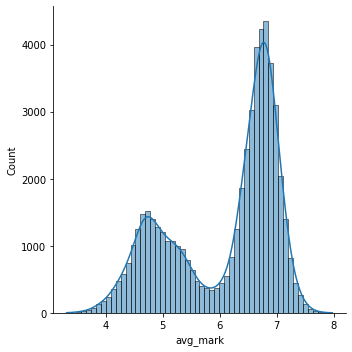

In [188]:
sns.displot(data=team_based_df_stat, x="avg_mark", kde=True)

<AxesSubplot: xlabel='avg_mark'>

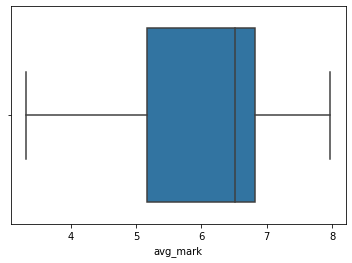

In [189]:
sns.boxplot(data=team_based_df_stat, x="avg_mark")#, y="class")

<AxesSubplot: xlabel='avg_mark', ylabel='result'>

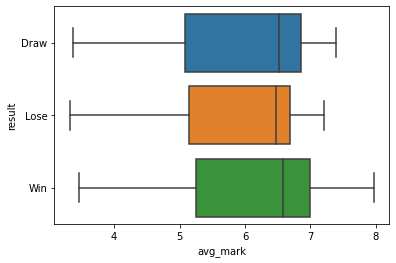

In [190]:
sns.boxplot(data=team_based_df_stat, x="avg_mark", y="result")

<ipython-input-191-6bbedfd28370>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_based_df_stat['team_score'] = team_based_df_stat['team_score'].astype('str')


<AxesSubplot: xlabel='avg_mark', ylabel='team_score'>

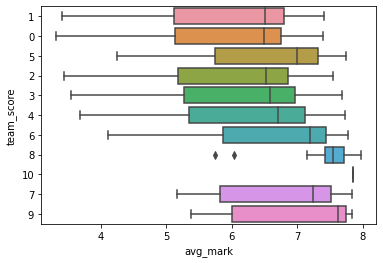

In [191]:
team_based_df_stat['team_score'] = team_based_df_stat['team_score'].astype('str')
sns.boxplot(data=team_based_df_stat, x="avg_mark", y="team_score")

In [192]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,match_id,wins,draws,loses,scored,mised,is_high_league,caption,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma
1131,85984,Venezia,Ascoli,Home,517,507,Lose,2426.70,2524.99,-98.29,0.36,-0.186512,1,0,903695,53,60,64,204,224,0,Venezia-Ascoli,3,2,1,8,6,3,0,0,4,1,2,3,6,3,3.750,12.500,1.625,0.52125
509,85338,Las Palmas,Lugo,Away,534,716,Win,2503.27,2476.07,27.20,0.54,0.051614,0,1,878530,95,92,116,345,410,0,Las Palmas-Lugo,4,2,2,18,11,1,1,2,5,7,2,-1,8,4,4.250,11.750,2.875,0.61500
1197,85952,Huddersfield,Millwall,Home,37,58,Win,2451.02,2462.62,-11.60,0.48,-0.022012,1,0,880964,146,119,203,521,691,0,Huddersfield-Millwall,7,1,4,16,14,4,1,1,8,3,3,3,12,6,4.375,7.375,2.750,0.46625


In [193]:
team_based_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,avg_mark
84291,42020,946672,2022-09-08,Slovan Bratislava,FK Zalgiris Vilnius,Home,Draw,0,0,656,586,67,84313,1,0.5,1,0,0,1,25,15,27,97,100,World,UEFA Europa Conference League,848,2022,1,Štadión Tehelné pole,0.0,0.0,0.0,1,Draw,2404.92,2386.33,18.59,0.53,0,1,0,0,0,0,1,0,0,0,0,0,1,1,5.0,11.0,16.0,0.0,8.0,8.0,16.0,0.0,3.0,0.57,2.0,0.0,1.0,511.0,421.0,0.82,Home,2022-12-11 13:35:46.821950,0.3125,4.754545
23682,24755,556438,2015-11-08,FC Heidenheim,SC Paderborn 07,Away,Draw,1,1,180,185,48,23681,1,0.5,1,0,0,0,17,15,16,64,55,Germany,2. Bundesliga,79,2015,14,Benteler-Arena,0.0,0.0,0.0,0,Draw,2570.73,2438.44,132.29,0.68,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.0000,0.000000
13332,37052,541622,2014-07-17,ST Johnstone,FC Luzern,Away,Draw,1,1,258,644,1,13350,1,0.5,1,0,0,0,0,1,0,1,1,World,UEFA Europa League,3,2014,2nd Qualifying Round,swissporarena,0.0,0.0,0.0,1,Draw,2478.34,2456.66,21.68,0.53,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.0000,0.000000


In [194]:
team_based_df[team_based_df['id']==85023]

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,avg_mark
85023,42396,880872,2022-10-05,Preston,West Brom,Home,Win,1,0,59,60,334,85023,3,1.0,0,0,1,1,121,102,111,397,391,England,Championship,40,2022,13,Deepdale,3.1,3.1,2.35,0,Win,2460.58,2498.41,-37.83,0.45,2,1,4,7,11,1,1,2,4,5,-2,-1,7,4,4.0,3.0,9.0,2.0,6.0,3.0,9.0,2.0,0.0,0.34,2.0,0.0,5.0,301.0,211.0,0.7,Home,2022-12-11 13:36:23.758199,0.444444,5.905556


In [195]:
train_df = train_df.merge(
                indiv_mark, 'left', on=['match_id', 'team_id'], suffixes=('', '_indiv')
                                    ).fillna(0)

train_df['avg_mark_ma'] = np.where(
                    train_df['game_number'] <= 10, train_df['avg_mark'],
                    train_df.groupby('team_id')['avg_mark'].transform(lambda x: x.rolling(8, 1).mean())
                              )

fresh_df = train_df[
    train_df['game_number'] == train_df['last_game']
                    ]



In [196]:
stat_dct = fresh_df[['team_id', 'avg_mark_ma']]


test_df = test_df.merge(
                stat_dct, 'left', on=['team_id'], suffixes=('', '_stat')
                                    ).fillna(0)

In [197]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,match_id,wins,draws,loses,scored,mised,is_high_league,caption,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,avg_mark_ma
523,85317,Barcelona,Inter,Home,529,505,Draw,2785.61,2811.47,-25.86,0.46,-0.049071,1,0,946934,339,90,68,1214,465,1,Barcelona-Inter,3,1,0,7,3,2,0,0,4,1,3,2,4,2,6.875,10.750,2.500,0.6475,1.779348
359,85132,Millwall,Middlesbrough,Home,58,70,Win,2462.62,2463.93,-1.31,0.50,-0.002486,1,0,880824,123,122,144,426,494,0,Millwall-Middlesbrough,5,5,6,16,26,3,2,3,9,13,-1,0,16,8,4.000,11.625,1.625,0.4475,4.868056
101,84853,Paris Saint Germain,Nice,Home,85,84,Win,2873.86,2612.83,261.03,0.82,0.495322,1,0,871615,336,84,64,1146,398,1,Paris Saint Germain-Nice,13,3,3,40,15,6,3,0,19,6,10,6,19,9,7.250,9.125,2.375,0.6000,4.015769


In [198]:
train_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,last_game,avg_mark,avg_mark_ma
13061,28401,186675,2014-05-17,Nantes,Bastia,Away,Draw,0,0,83,1305,76,13068,1,0.5,1,0,0,1,32,22,22,94,72,France,Ligue 1,61,2013,38,Stade Armand Césari (Furiani),0.0,0.0,0.0,1,Draw,2533.53,2479.39,54.14,0.58,0.094759,0,1,1,1,0,2,0,0,1,0,0,0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.000000,0.00,0.00,0.00,0.00000,382,0.000000,0.00000
55121,1943,27474,2019-04-24,Athletic Club,Leganes,Away,Win,1,0,531,537,309,55114,3,1.0,0,0,1,1,128,79,102,415,382,Spain,La Liga,140,2018,34,Municipal de Butarque,0.0,0.0,0.0,1,Win,2584.30,2544.90,39.40,0.56,0.068598,0,1,3,2,1,6,3,1,1,1,1,1,2,0,6,3,2.0,1.0,3.0,0.0,2.0,1.0,14.0,2.0,0.0,0.44,2.0,0.0,1.0,364.0,264.0,0.73,Away,2022-09-15 09:13:13.453335,0.666667,4.75,14.25,1.50,0.48625,432,6.400000,6.70522
77250,19941,747179,2021-11-28,como,Parma,Home,Draw,1,1,895,523,14,77261,1,0.5,1,0,0,0,5,5,4,21,18,Italy,Serie B,136,2021,14,Stadio Giuseppe Sinigaglia,0.0,0.0,0.0,0,Draw,2458.64,2476.64,-18.00,0.47,-0.033278,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,1,5.0,1.0,13.0,7.0,9.0,4.0,9.0,5.0,2.0,0.48,2.0,0.0,5.0,373.0,286.0,0.77,Home,2022-10-04 05:33:12.535167,0.384615,5.50,13.75,1.75,0.40125,45,4.418182,4.43582


In [199]:
x_fields_minus_plus = [
                        'rating_difference',
                        'result_difference_peronal_meet'
                       ]

x_fields_zero_one = [
                        'wins', 'loses', 'avg_mark_ma'
                    ]
x_stable = [
                'is_Home', 'is_high_league',
            ]


In [200]:
X_train = pf.normalize_df(train_df, x_fields_minus_plus, x_fields_zero_one, x_stable)
X_test = pf.normalize_df(test_df, x_fields_minus_plus, x_fields_zero_one, x_stable)

y_train = train_df['y'].values
y_test = test_df['y'].values

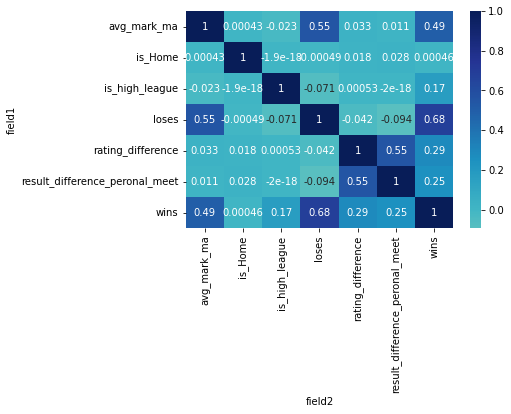

In [201]:
problems = pf.show_fields(X_train, 0.7)

In [202]:
problems

,correlation,field1,field2


In [203]:
mark_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
mark_clf.fit(X_train, y_train)
y_mark = mark_clf.predict(X_test)
work_df['marks_predict'] = y_mark

,size,accuracy,f1,roi,segment,model
0,1264,0.405063,0.385659,0.101512,1,with_individual_marks


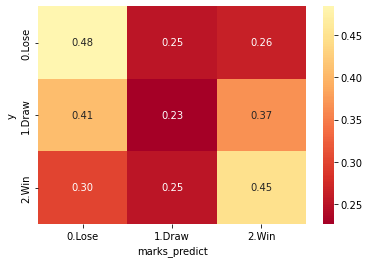

In [204]:
pf.model_results(work_df, 'with_individual_marks', 'marks_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

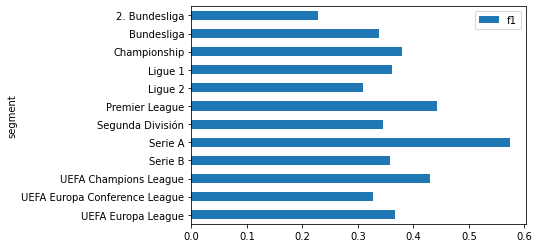

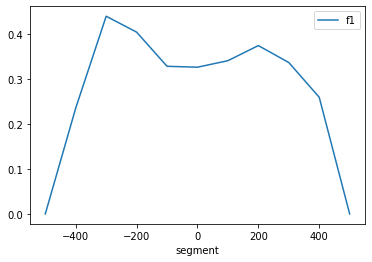

In [205]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'marks_predict', mark_clf, X_train.columns, predict_parameters)

In [206]:
hl

,size,accuracy,f1,roi,segment
0,694,0.452450,0.420583,0.349589,1
1,570,0.347368,0.339554,-0.180350,0


In [207]:
venue

,size,accuracy,f1,roi,segment
0,632,0.411392,0.388559,-0.290786,Home
1,632,0.398734,0.365705,0.490962,Away


In [208]:
fi

,feature,importance,position
0,result_difference_peronal_meet,0.328648,0
1,rating_difference,0.285253,1
2,wins,0.126934,2
3,loses,0.124622,3
4,avg_mark_ma,0.092319,4
5,is_Home,0.029779,5
6,is_high_league,0.012444,6


In [209]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo
6,1264,0.427215,0.408253,0.149049,with_pers_meets
7,1264,0.451741,0.433574,0.194575,pers_meets_hyperparams
8,1264,0.394778,0.383167,0.020932,with_match_stat
9,1264,0.405063,0.385659,0.101512,with_individual_marks


In [210]:
train_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,last_game,avg_mark,avg_mark_ma
20208,28003,186277,2015-05-09,Bordeaux,Nantes,Home,Win,2,1,78,83,112,20190,3,1.0,0,0,1,0,42,41,29,133,119,France,Ligue 1,61,2014,36,Stade Jacques Chaban-Delmas (Bordeaux),0.0,0.0,0.0,1,Win,2586.79,2539.08,47.71,0.57,0.083347,1,0,1,1,2,3,6,1,0,1,2,4,-1,0,4,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.0,0.0,0.0,0.0,0.000,403,0.000000,0.000000
2479,25675,557358,2012-11-23,VfR Aalen,Jahn Regensburg,Away,Win,3,1,1327,177,14,2476,3,1.0,0,0,1,0,7,2,5,18,12,Germany,2. Bundesliga,79,2012,15,Städtisches Jahnstadion,0.0,0.0,0.0,0,Win,2474.87,2409.87,65.00,0.59,0.114034,0,1,1,0,0,3,1,1,0,0,3,1,1,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.0,0.0,0.0,0.0,0.000,101,0.000000,0.000000
34044,18069,21435,2017-02-10,Napoli,Genoa,Home,Win,2,0,492,495,212,34021,3,1.0,0,0,1,1,125,48,39,429,222,Italy,Serie A,135,2016,24,Stadio San Paolo,0.0,0.0,0.0,1,Win,2681.54,2476.73,204.81,0.76,0.362175,1,0,7,3,0,18,6,4,1,0,10,3,7,4,10,5,8.0,8.0,20.0,4.0,11.0,9.0,7.0,12.0,0.0,0.57,1.0,0.0,2.0,585.0,486.0,0.83,Home,2022-09-29 04:15:50.534598,0.4,8.5,9.5,2.0,0.615,473,7.357143,7.163668


In [211]:
train_df[
    (train_df['league_name']=='Serie A') &(train_df['season']==2022)
].groupby('team').mean()[[
    'shots_on_goal', 'total_shots', 'ball_possession'
                    ]].sort_values(by=['shots_on_goal', 'ball_possession'], ascending=[False, False])

,shots_on_goal,total_shots,ball_possession
team,,,
Inter,6.142857,17.571429,0.564286
AS Roma,6.142857,16.571429,0.484286
Napoli,5.571429,19.285714,0.592857
Fiorentina,5.285714,16.285714,0.608571
AC Milan,5.000000,17.142857,0.528571
Lazio,5.000000,11.000000,0.494286
Sassuolo,5.000000,13.142857,0.487143
Salernitana,4.428571,13.285714,0.501429
Atalanta,4.285714,11.142857,0.457143


In [212]:
train_df[
    (train_df['league_name']=='Serie A') & (train_df['season']==2022) &
    (train_df['team']=='Sassuolo')
][[ 'team', 'opponent', 'team_score', 'opponent_score',
    'shots_on_goal', 'total_shots', 'ball_possession'
                    ]]

,team,opponent,team_score,opponent_score,shots_on_goal,total_shots,ball_possession
83356,Sassuolo,Juventus,0,3,7.0,19.0,0.58
83532,Sassuolo,Lecce,1,0,3.0,12.0,0.59
83790,Sassuolo,Spezia,2,2,8.0,21.0,0.58
83937,Sassuolo,AC Milan,0,0,3.0,8.0,0.38
84178,Sassuolo,Cremonese,0,0,7.0,17.0,0.54
84447,Sassuolo,Udinese,1,3,2.0,5.0,0.32
84680,Sassuolo,Torino,1,0,5.0,10.0,0.42


## Model #10: Expected rating

In [213]:
expect_df = train_df[[
    'match_id', 'team_id', 
    'team_score', 'opponent_score',
    'shots_on_goal', 'total_shots', 'ball_possession', 'opponent_team_id'
                    ]]
expect_df = expect_df.merge(
                            expect_df, 
                            left_on=['opponent_team_id', 'match_id'], 
                            right_on=['team_id', 'match_id'], 
                            suffixes=('', '_opponent')
                            )

expect_df = expect_df[[
       'match_id', 'team_id', 'opponent_team_id',
       'team_score', 'opponent_score', 
       'shots_on_goal','shots_on_goal_opponent',
       'total_shots', 'total_shots_opponent',
       'ball_possession', 'ball_possession_opponent'
]]

expect_df['ex_value'] =   (100 * np.sign(expect_df['shots_on_goal'] - expect_df['shots_on_goal_opponent']) 
                          + 10 * np.sign(expect_df['total_shots'] - expect_df['total_shots_opponent'])
                           + 1 * np.sign(expect_df['ball_possession'] - expect_df['ball_possession_opponent']))
expect_df['ex_team_score'] = np.where(
    expect_df['ex_value'] > 0, expect_df['team_score'] + 1, expect_df['team_score'])
expect_df['ex_opponent_score'] = np.where(
    expect_df['ex_value'] < 0, expect_df['opponent_score'] + 1, expect_df['opponent_score'])

expect_df['ex_result']=np.where(
    (expect_df['ex_team_score']>expect_df['ex_opponent_score']), 'Win', 
                                np.where(
                                    (expect_df['ex_team_score']<expect_df['ex_opponent_score']), 'Lose', 'Draw'
                                        )
                            )
expect_df['ex_score'] = np.where(
                                    expect_df['ex_result']=='Win', 1,
                                    np.where(
                                        expect_df['ex_result']=='Draw', 0.5, 0
                                            )
                                  )

In [214]:
expect_df['score'] = expect_df['ex_score']
expect_df = expect_df.merge(train_df, 'left', on=['match_id', 'team_id'], suffixes=('', '_add'))

In [215]:
expect_df.sample(3)

,match_id,team_id,opponent_team_id,team_score,opponent_score,shots_on_goal,shots_on_goal_opponent,total_shots,total_shots_opponent,ball_possession,ball_possession_opponent,ex_value,ex_team_score,ex_opponent_score,ex_result,ex_score,score,index,date,team,opponent,venue,result,team_score_add,opponent_score_add,opponent_team_id_add,game_number,id,points,score_add,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal_add,shots_off_goal,total_shots_add,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession_add,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,last_game,avg_mark,avg_mark_ma
33512,21465,488,525,3,1,5.0,5.0,16.0,19.0,0.56,0.44,-9.0,3,2,Win,1.0,1.0,18099,2017-01-22,Sassuolo,Pescara,Away,Win,3,1,525,145,33522,3,1.0,0,0,1,0,47,40,58,189,217,Italy,Serie A,135,2016,21,Stadio Adriatico-Giovanni Cornacchia,0.0,0.0,0.0,1,Win,2526.10,2306.95,219.15,0.78,0.387626,0,1,1,0,1,3,4,1,0,0,3,1,0,1,2,1,5.0,8.0,16.0,3.0,8.0,8.0,24.0,6.0,0.0,0.56,5.0,0.0,3.0,522.0,408.0,0.78,Away,2022-09-29 04:12:31.332060,0.3125,4.125,16.250,1.50,0.47000,359,7.207143,6.945192
57330,368844,339,257,0,1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0,1,Lose,0.0,0.0,34504,2019-08-29,Legia Warszawa,Rangers,Away,Lose,0,1,257,66,57335,0,0.0,0,1,0,0,31,18,17,86,66,World,UEFA Europa League,3,2019,Play-offs,Ibrox Stadium,0.0,0.0,0.0,1,Lose,2487.12,2552.98,-65.86,0.41,-0.118222,0,1,0,1,1,0,1,0,0,1,0,1,-1,-1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.0000,0.000,0.000,0.00,0.00000,84,0.000000,0.000000
80661,719593,178,169,0,0,2.0,6.0,4.0,21.0,0.32,0.68,-111.0,0,1,Lose,0.0,0.0,39333,2022-04-02,SpVgg Greuther Furth,Eintracht Frankfurt,Away,Draw,0,0,169,334,80681,1,0.5,1,0,0,1,106,97,131,419,498,Germany,Bundesliga,78,2021,28,Deutsche Bank Park,0.0,0.0,0.0,1,Draw,2556.77,2680.70,-123.93,0.33,-0.221287,0,1,0,2,2,4,6,0,2,0,1,1,-2,0,4,2,2.0,1.0,4.0,1.0,2.0,2.0,14.0,0.0,5.0,0.32,0.0,0.0,6.0,313.0,225.0,0.72,Away,2022-09-28 09:18:17.380725,0.5000,3.375,13.625,2.25,0.39875,349,5.070000,5.106185


In [216]:
expect_df, ex_current_rating_dict = pf.count_elo_rating_df(expect_df)

In [217]:
expect_df.sample(3)

,match_id,team_id,opponent_team_id,team_score,opponent_score,shots_on_goal,shots_on_goal_opponent,total_shots,total_shots_opponent,ball_possession,ball_possession_opponent,ex_value,ex_team_score,ex_opponent_score,ex_result,ex_score,score,index,date,team,opponent,venue,result,team_score_add,opponent_score_add,opponent_team_id_add,game_number,id,points,score_add,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal_add,shots_off_goal,total_shots_add,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession_add,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,last_game,avg_mark,avg_mark_ma
62861,209199,160,159,2,1,7.0,5.0,19.0,11.0,0.49,0.51,109.0,3,1,Win,1.0,1.0,39990,2020-06-16,SC Freiburg,Hertha Berlin,Home,Win,2,1,159,272,62858,3,1.0,0,0,1,0,95,76,101,363,410,Germany,Bundesliga,78,2019,32,Schwarzwald-Stadion,0.0,0.0,0.0,1,Win,2531.90,2573.50,-41.60,0.44,0.023801,1,0,4,6,2,14,11,3,3,0,10,7,2,3,12,6,7.0,1.0,19.0,11.0,11.0,8.0,6.0,5.0,1.0,0.49,0.0,0.0,4.0,399.0,321.0,0.80,Home,2022-09-28 08:59:05.974416,0.368421,4.375,9.125,2.375,0.44375,351,6.506250,6.620964
33503,21047,798,729,1,1,3.0,7.0,10.0,12.0,0.37,0.63,-111.0,1,2,Lose,0.0,0.0,5221,2017-01-22,Mallorca,Reus,Away,Draw,1,1,729,60,33497,1,0.5,1,0,0,0,14,18,28,65,97,Spain,Segunda División,141,2016,22,Estadio Municipal de Reus,0.0,0.0,0.0,0,Draw,2421.13,2453.76,-32.63,0.45,-0.079424,0,1,0,1,1,1,2,0,1,0,1,1,-1,0,2,1,3.0,7.0,10.0,0.0,5.0,5.0,17.0,1.0,0.0,0.37,4.0,1.0,6.0,304.0,224.0,0.74,Away,2022-09-15 10:57:26.806514,0.300000,3.125,14.875,1.500,0.48625,248,6.428571,6.588393
13107,541658,4628,651,1,1,0.0,0.0,0.0,0.0,0.00,0.00,0.0,1,1,Draw,0.5,0.5,37085,2014-07-01,Sliema Wanderers,Ferencvarosi TC,Home,Draw,1,1,651,1,13112,1,0.5,1,0,0,0,0,1,0,1,1,World,UEFA Europa League,3,2014,1st Qualifying Round,Ta'Qali National Stadium,0.0,0.0,0.0,1,Draw,2195.72,2364.28,-168.56,0.27,-0.300499,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0,0,0.000000,0.000,0.000,0.000,0.00000,2,0.000000,0.000000


<AxesSubplot: xlabel='game_number'>

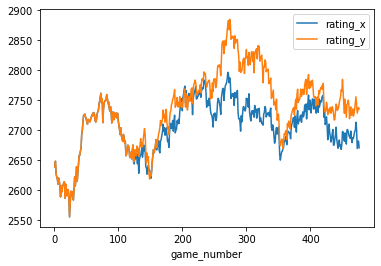

In [218]:
tem_example = 'AS Roma'
expected = expect_df[expect_df['team']==tem_example][[
    'game_number','rating']]
classic = train_df[train_df['team']==tem_example][[
    'game_number','rating']]

ex_comp = classic.merge(expected, 'left', on='game_number')
ex_comp.set_index('game_number').plot()

<AxesSubplot: xlabel='game_number'>

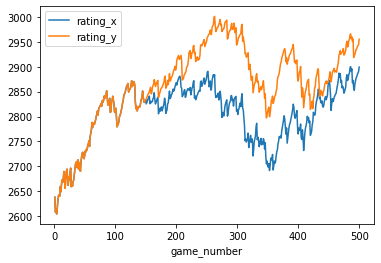

In [219]:
tem_example = 'Real Madrid'
expected = expect_df[expect_df['team']==tem_example][[
    'game_number','rating']]
classic = train_df[train_df['team']==tem_example][[
    'game_number','rating']]

ex_comp = classic.merge(expected, 'left', on='game_number')
ex_comp.set_index('game_number').plot()

In [220]:
expect_df['ex_rating'] = expect_df['rating']
expect_df['ex_opponent_rating'] = expect_df['opponent_rating']

train_df = train_df.merge(
    expect_df[['match_id', 'team_id', 'ex_rating', 'ex_opponent_rating']],
    on=['match_id', 'team_id']
)
train_df['ex_rating_difference'] = train_df['ex_rating'] - train_df['ex_opponent_rating']

In [221]:
test_df['ex_rating'] = test_df['team'].map(ex_current_rating_dict) 
test_df['ex_opponent_rating'] = test_df['opponent'].map(ex_current_rating_dict) 
test_df['ex_rating_difference'] = test_df['ex_rating'] - test_df['ex_opponent_rating']

In [222]:
train_df.sample(3)

,index,match_id,date,team,opponent,venue,result,team_score,opponent_score,team_id,opponent_team_id,game_number,id,points,score,is_Draw,is_Lose,is_Win,is_dry_match,wins,draws,loses,scored,mised,coutry,league_name,league_id,season,round,stadium,cf1,cfdr,cf2,is_high_league,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal,shots_off_goal,total_shots,blocked_shots,shots_insidebox,shots_outsidebox,fouls,corner_kicks,offsides,ball_possession,yellow_cards,red_cards,goalkeeper_saves,total_passes,passes_accurate,passes_percentage,venue_stat,insert_time,shots_accuracy,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,last_game,avg_mark,avg_mark_ma,ex_rating,ex_opponent_rating,ex_rating_difference
75820,39154,719414,2021-10-17,Bayer Leverkusen,Bayern Munich,Home,Lose,1,5,168,157,380,75823,0,0.0,0,1,0,0,187,81,112,675,488,Germany,Bundesliga,78,2021,8,BayArena,0.0,0.0,0.0,1,Lose,2714.07,2915.72,-201.65,0.24,-0.359228,1,0,4,3,12,20,36,2,3,5,12,18,-8,-3,19,10,4.0,1.0,6.0,1.0,4.0,2.0,9.0,4.0,1.0,0.41,0.0,0.0,6.0,446.0,374.0,0.84,Home,2022-09-28 08:53:46.045532,0.666667,6.625,10.000,1.00,0.5275,422,5.140000,5.431685,2746.56,2986.42,-239.86
59919,7548,157146,2019-11-30,West Ham,Chelsea,Away,Win,1,0,48,49,289,59950,3,1.0,0,0,1,1,96,76,117,371,420,England,Premier League,39,2019,14,Stamford Bridge,0.0,0.0,0.0,1,Win,2602.15,2757.58,-155.43,0.29,-0.277195,0,1,4,4,7,12,19,1,3,4,5,11,-3,-3,15,8,4.0,1.0,5.0,0.0,5.0,0.0,16.0,3.0,0.0,0.35,3.0,0.0,6.0,354.0,248.0,0.70,Away,2022-09-28 09:02:29.786368,0.800000,4.500,11.125,2.25,0.5275,411,6.964286,6.741964,2592.41,2828.04,-235.63
25448,9170,192530,2016-02-02,Southampton,Arsenal,Away,Draw,0,0,41,42,142,25450,1,0.5,1,0,0,1,53,39,50,195,165,England,Premier League,39,2015,24,Emirates Stadium,0.0,0.0,0.0,1,Draw,2628.37,2695.76,-67.39,0.40,-0.120938,0,1,2,3,3,10,12,0,1,3,1,9,-1,-3,8,4,3.0,4.0,14.0,7.0,6.0,8.0,0.0,3.0,2.0,0.34,1.0,0.0,10.0,274.0,179.0,0.65,Away,2022-09-29 04:40:14.455385,0.214286,4.125,2.125,3.00,0.4750,397,7.178571,6.934821,2654.33,2683.36,-29.03


In [223]:
test_df.sample(3)

,id,team,opponent,venue,team_id,opponent_team_id,y,rating,opponent_rating,rating_difference,elo_propability,rating_difference_normalized,is_Home,is_Away,match_id,wins,draws,loses,scored,mised,is_high_league,caption,wins_peronal_meet,draws_peronal_meet,loses_peronal_meet,scored_peronal_meet,missed_peronal_meet,wins_venue,draws_venue,loses_venue,scored_venue,missed_venue,result_difference_peronal_meet,result_difference_venue,games_peronal_meet,games_venue,shots_on_goal_ma,fouls_ma,offsides_ma,ball_possession_ma,avg_mark_ma,ex_rating,ex_opponent_rating,ex_rating_difference
489,85290,Real Madrid,Shakhtar Donetsk,Away,541,550,Draw,2899.41,2687.49,211.92,0.77,0.402133,0,1,946937,341,88,75,1199,498,1,Real Madrid-Shakhtar Donetsk,4,0,2,17,9,2,0,1,9,5,2,1,6,3,6.375,7.500,2.375,0.57875,3.006766,2955.38,2664.16,291.22
1162,85943,FSV Mainz 05,Bayern Munich,Away,164,157,Lose,2620.04,2871.65,-251.61,0.19,-0.477447,0,1,871292,122,88,153,475,554,1,FSV Mainz 05-Bayern Munich,3,1,16,19,57,1,1,8,10,35,-13,-7,20,10,4.250,12.625,2.375,0.48375,3.949653,2657.53,3016.46,-358.93
124,84927,Huesca,Granada CF,Away,726,715,Draw,2421.84,2549.94,-128.10,0.32,-0.243079,0,1,878528,92,81,92,313,306,0,Huesca-Granada CF,2,1,1,8,8,0,1,1,3,5,1,-1,4,2,2.500,13.000,1.250,0.39875,2.488946,2465.04,2568.13,-103.09


In [224]:
train_df[['rating_difference', 'ex_rating_difference']].describe()

,rating_difference,ex_rating_difference
count,84816.000000,84816.000000
mean,-0.011400,-0.016687
std,126.795267,141.201289
min,-562.680000,-601.840000
25%,-75.800000,-84.722500
50%,-0.175000,-0.165000
75%,75.960000,85.112500
max,564.180000,603.060000


In [225]:
x_fields_minus_plus = [
                        'rating_difference',
                        'result_difference_peronal_meet',
                        'ex_rating_difference'
                       ]

x_fields_zero_one = [
                        'wins', 'loses', 
                    ]
x_stable = [
                'is_Home', 'is_high_league',
            ]

X_train = pf.normalize_df(train_df, x_fields_minus_plus, x_fields_zero_one, x_stable)
X_test = pf.normalize_df(test_df, x_fields_minus_plus, x_fields_zero_one, x_stable)

y_train = train_df['y'].values
y_test = test_df['y'].values

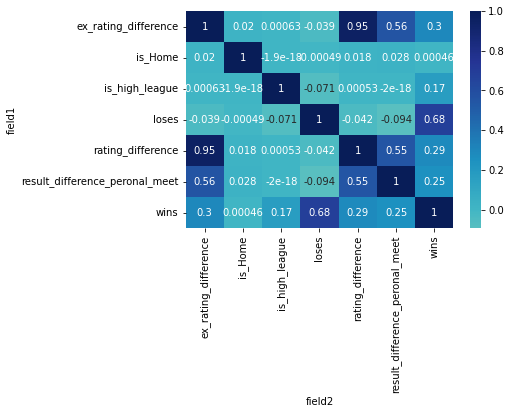

In [226]:
problems = pf.show_fields(X_train, 0.7)

In [227]:
problems

,correlation,field1,field2
2,0.95141,rating_difference,ex_rating_difference
14,0.95141,ex_rating_difference,rating_difference


In [228]:
ex_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
ex_clf.fit(X_train, y_train)
y_ex = ex_clf.predict(X_test)
work_df['ex_predict'] = y_ex

,size,accuracy,f1,roi,segment,model
0,1264,0.4375,0.42206,0.170337,1,with_ex_metrics


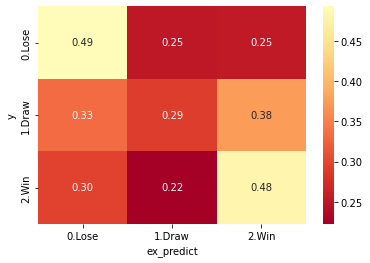

In [229]:
pf.model_results(work_df, 'with_ex_metrics', 'ex_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

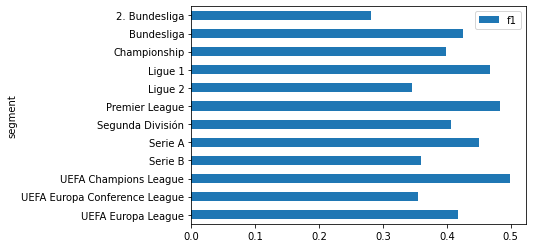

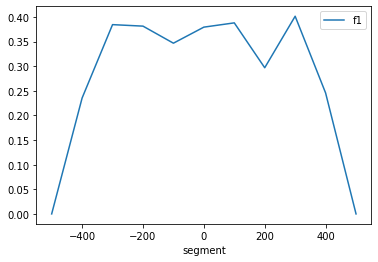

In [230]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'ex_predict', ex_clf, X_train.columns, predict_parameters)

In [231]:
venue

,size,accuracy,f1,roi,segment
1,632,0.446203,0.425360,0.613058,Away
0,632,0.428797,0.407752,-0.269907,Home


In [232]:
hl

,size,accuracy,f1,roi,segment
0,694,0.481268,0.451132,0.417178,1
1,570,0.384211,0.380318,-0.108466,0


In [233]:
fi

,feature,importance,position
0,result_difference_peronal_meet,0.291222,0
1,rating_difference,0.259122,1
2,ex_rating_difference,0.160098,2
3,wins,0.128374,3
4,loses,0.121494,4
5,is_Home,0.027692,5
6,is_high_league,0.011997,6


In [234]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo
6,1264,0.427215,0.408253,0.149049,with_pers_meets
7,1264,0.451741,0.433574,0.194575,pers_meets_hyperparams
8,1264,0.394778,0.383167,0.020932,with_match_stat
9,1264,0.405063,0.385659,0.101512,with_individual_marks


In [235]:
%%time
if is_hyper_search == 1:
    n_range = range(6, 20)
    d_range = range(7, 24)

    # parameter for tests
#     n_range = range(4, 7)
#     d_range = range(4, 7)

    best_n, best_depth = pf.hypeparams_fit(
                                            X_train, y_train, 
                                            X_test, test_df,
                                            n_range,
                                            d_range,
                                        )
else:
    best_n = 11
    best_depth = 17

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [236]:
best_ex_clf = RandomForestClassifier(
                    n_estimators=best_n,
                    max_depth=best_depth,
                    random_state=22)
best_ex_clf.fit(X_train, y_train)
y_best_ex = best_ex_clf.predict(X_test)
work_df['best_ex_predict'] = y_best_ex

,size,accuracy,f1,roi,segment,model
0,1264,0.447785,0.434051,0.218322,1,with_best_ex_metrics


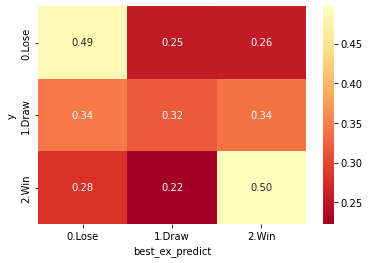

In [237]:
pf.model_results(work_df, 'with_best_ex_metrics', 'best_ex_predict', predict_parameters)

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(
/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

/home/roman_vm/python/sport/predict_fucntions.py:780: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['revenue'] = test_df[['y', predict, 'cf1', 'cfdr', 'cf2']].apply(


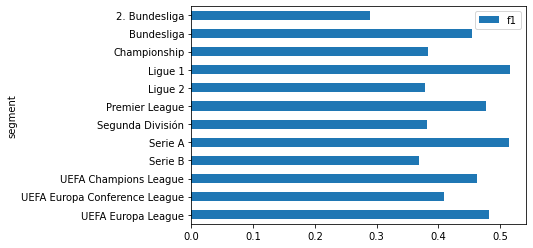

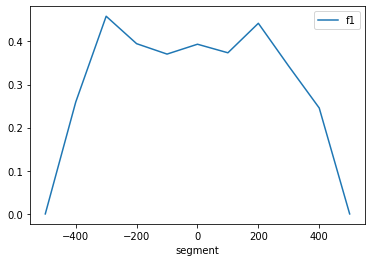

In [238]:
hl, leagues, venue, fi, comparison_df = pf.watching(
    work_df, 'best_ex_predict', best_ex_clf, X_train.columns, predict_parameters)

In [239]:
hl

,size,accuracy,f1,roi,segment
0,694,0.504323,0.480410,0.523429,1
1,570,0.378947,0.373961,-0.118679,0


In [240]:
venue

,size,accuracy,f1,roi,segment
1,632,0.46519,0.442218,0.704532,Away
0,632,0.43038,0.408726,-0.268799,Home


In [241]:
fi

,feature,importance,position
0,result_difference_peronal_meet,0.265878,0
1,rating_difference,0.262297,1
2,ex_rating_difference,0.168216,2
3,wins,0.133404,3
4,loses,0.131448,4
5,is_Home,0.026819,5
6,is_high_league,0.011938,6


In [242]:
comparison_df

,games,accuracy,f1,roi,model_name
0,1264,0.254747,0.135351,-0.428706,random
1,1264,0.372627,0.180980,-0.316536,simple_predict
2,1264,0.422468,0.413507,0.145019,direct_elo
3,1264,0.462025,0.370062,0.208819,random_forest_elo
4,1264,0.478639,0.370284,0.262411,real_random_forest_elo
5,1264,0.477057,0.418005,0.261422,best_params_elo
6,1264,0.427215,0.408253,0.149049,with_pers_meets
7,1264,0.451741,0.433574,0.194575,pers_meets_hyperparams
8,1264,0.394778,0.383167,0.020932,with_match_stat
9,1264,0.405063,0.385659,0.101512,with_individual_marks


In [243]:
# def get_clust(df):
#     from sklearn.manifold import TSNE
#     from sklearn.preprocessing import StandardScaler

#     X = df.copy().fillna(0)
# #     X = X.drop(columns=['team', 'season'])

#     # X['International plan'] = pd.factorize(X['International plan'])[0]
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)

#     tsne = TSNE(random_state=17)
#     tsne_representation = tsne.fit_transform(X_scaled)

#     clust_df = pd.DataFrame(tsne_representation, columns=['x', 'y'])

#     sns.scatterplot(data=clust_df, x='x', y='y')
    
#     return clust_df

In [244]:
# clust_df = get_clust(
#             overall[[
#                 'games', 'wins', 'score_diff', 'goals_per_game',
#                 'dryality', 'win_rate', 'peacefullaty',
#                 'shots', 'shots_accuracy', 'ball_possession', 
#                 'passes', 'passes_accuracy', 'fouls'
#             ]]
#          )

In [245]:
# cl1 = clust_df[
#     (clust_df['x'] < -15)&
#     (clust_df['y'] > 10)
# ].index

# cl2 = clust_df[
#     (clust_df['x'] > -10) & (clust_df['x'] < 10) &
#     (clust_df['y'] > 10)
# ].index

In [246]:
# overall[overall.index.isin(cl2)]

In [247]:
# match = get_stat_df(team_based_df, ['match_id', 'team'])

In [248]:
# match[0:3]

In [249]:
# %%time
# clust_df = get_clust(
#             match[[
#                 'games', 'wins', 'score_diff', 'goals_per_game',
#                 'dryality', 'win_rate', 'peacefullaty',
#                 'shots', 'shots_accuracy', 'ball_possession', 
#                 'passes', 'passes_accuracy', 'fouls'
#             ]]
#          )

In [250]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=11, random_state=13).fit(clust_df)
 

In [251]:
# np.max(clust_df['kmeans_label'])

In [252]:
# sns.scatterplot(data=clust_df, x='x', y='y', hue='kmeans_label', palette='Set1')

In [253]:
# from sklearn.cluster import DBSCAN
# dbs = DBSCAN(eps=8, min_samples=5).fit(clust_df)
# clust_df['dbs_label'] = dbs.labels_

In [254]:
# np.max(clust_df['dbs_label'])

In [255]:
# sns.scatterplot(data=clust_df, x='x', y='y', hue='dbs_label', palette='Set1')

In [256]:
# match['dbs_label'] = clust_df['dbs_label']
# match['kmeans_label'] = clust_df['labels']

In [257]:
# match.groupby('dbs_label').mean().T

In [258]:
# %%time
# clust_df = get_clust(
#             match[[
# #                 'games', 'wins', 'score_diff', 
# #                 'goals_per_game',
# #                 'dryality', 
# #                 'win_rate', 
# #                 'peacefullaty',
#                 'shots', 'shots_accuracy', 'ball_possession', 
#                 'passes', 'passes_accuracy', 'fouls'
#             ]]
#          )

In [259]:
# from sklearn.cluster import DBSCAN
# dbs = DBSCAN(eps=3, min_samples=15).fit(clust_df)
# clust_df['dbs_label'] = dbs.labels_

In [260]:
# np.max(clust_df['dbs_label'])

In [261]:
# sns.scatterplot(data=clust_df, x='x', y='y', hue='dbs_label', palette='Set1')

In [262]:
# match['dbs_label_nor'] = clust_df['dbs_label']

In [263]:
# match.groupby('dbs_label_nor').mean().T